# Chapter 7: Ensemble Learning and Random Forests

## Comprehensive Theory, Implementation, and Analysis

**Based on Hands-On Machine Learning by Aurélien Géron**

---

### Table of Contents
1. [Introduction to Ensemble Learning](#introduction)
2. [Voting Classifiers](#voting)
3. [Bagging and Pasting](#bagging)
4. [Random Forests](#random-forests)
5. [Boosting Algorithms](#boosting)
6. [Stacking](#stacking)
7. [Exercises and Solutions](#exercises)

---

## Setup and Imports

First, let's install necessary packages and set up our environment for Google Colab.

In [45]:
# Install additional packages if needed
!pip install -q xgboost

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Sklearn imports
from sklearn.datasets import make_moons, load_iris, fetch_openml
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report

# Ensemble methods
from sklearn.ensemble import (
    VotingClassifier, BaggingClassifier, RandomForestClassifier,
    ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingRegressor,
    GradientBoostingClassifier, RandomForestRegressor, BaggingRegressor
)

# Individual classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier

# XGBoost
import xgboost as xgb

# Set random state for reproducibility
np.random.seed(42)

# Configure plotting
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

print("Environment setup complete!")

Environment setup complete!


# 1. Introduction to Ensemble Learning

## Theoretical Foundation

**Ensemble Learning** is based on the principle of the "wisdom of the crowd" - aggregating predictions from multiple models often yields better results than any individual model.

### Mathematical Foundation

Consider $N$ classifiers $h_1, h_2, ..., h_N$ with individual error rates $\epsilon_i$. For a majority vote ensemble:

**Error Rate of Ensemble:**
$$P(\text{ensemble error}) = \sum_{k=\lceil N/2 \rceil}^{N} \binom{N}{k} \epsilon^k (1-\epsilon)^{N-k}$$

Where $\epsilon$ is the average error rate of individual classifiers.

### Key Principles:

1. **Diversity**: Classifiers should make different types of errors
2. **Independence**: Errors should be uncorrelated
3. **Accuracy**: Individual classifiers should be better than random guessing

### Law of Large Numbers in Ensemble Context

Consider a biased coin with probability $p = 0.51$ of heads. For $n$ tosses:

$$P(\text{majority heads}) = \sum_{k=\lceil n/2 \rceil}^{n} \binom{n}{k} p^k (1-p)^{n-k}$$

As $n \to \infty$, this probability approaches 1.

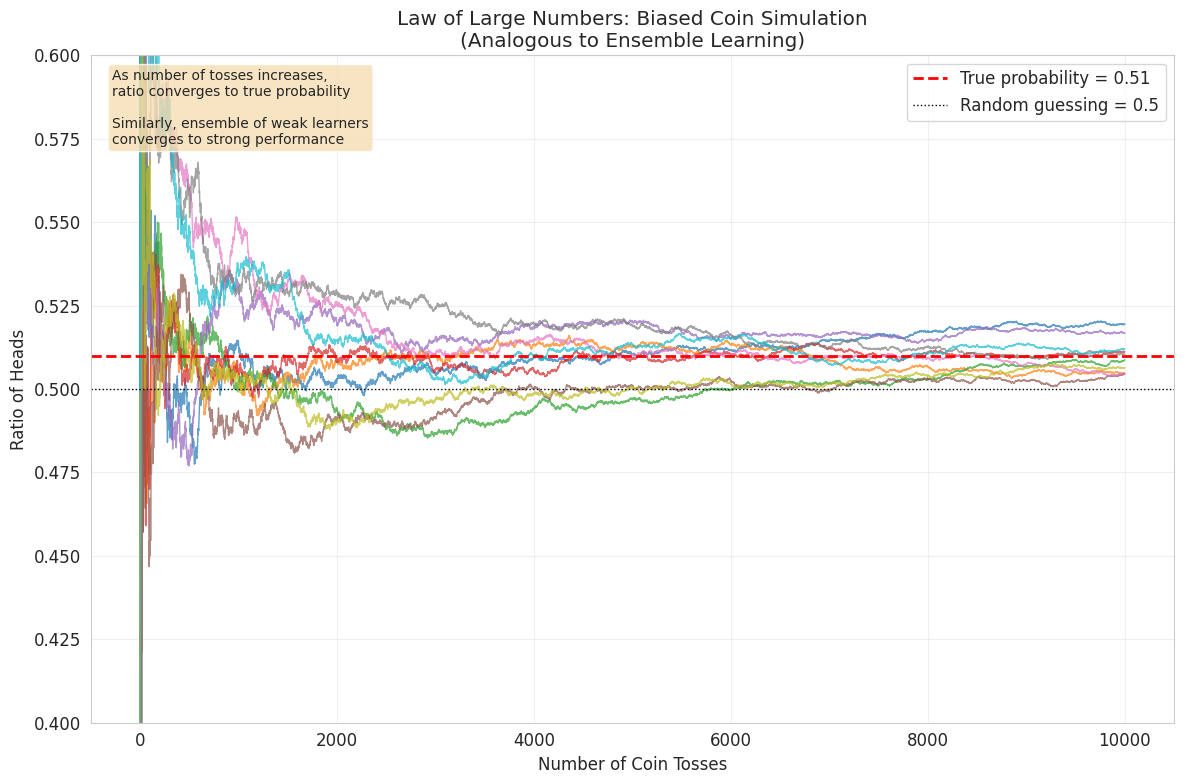

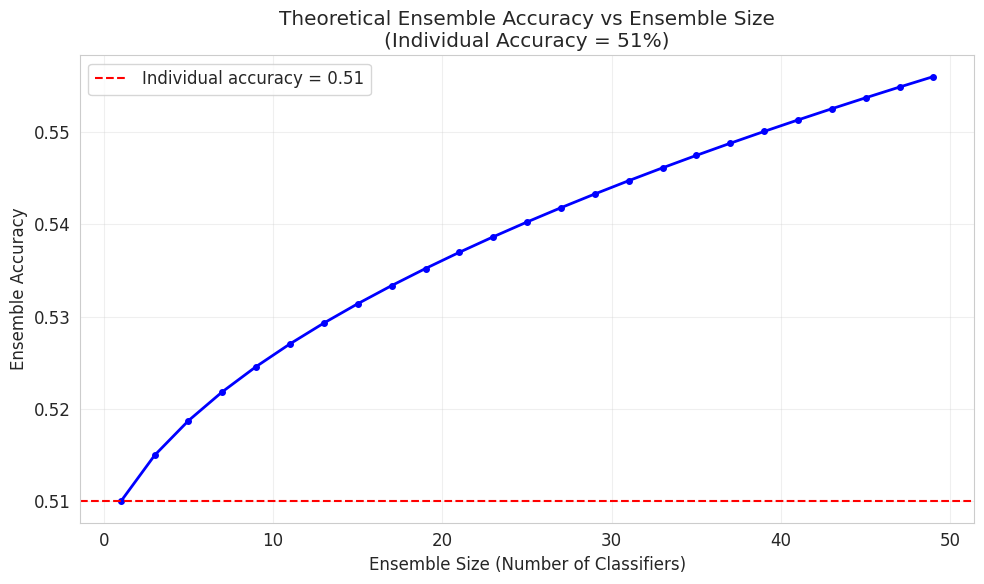

With individual accuracy of 0.51:
Ensemble of 1 classifier: 0.5100
Ensemble of 11 classifiers: 0.5271
Ensemble of 21 classifiers: 0.5370
Ensemble of 51 classifiers: 0.5560


In [46]:
# Demonstration of Law of Large Numbers with Biased Coin
def simulate_coin_tosses(p_heads=0.51, max_tosses=10000, num_series=10):
    """
    Simulate multiple series of biased coin tosses to demonstrate
    how the ratio converges to the true probability.

    This simulates the ensemble learning principle where individual
    weak learners (slightly better than random) combine to create
    a strong learner.
    """
    toss_counts = np.arange(1, max_tosses + 1)

    plt.figure(figsize=(12, 8))

    for series in range(num_series):
        # Generate random tosses (1 = heads, 0 = tails)
        tosses = np.random.random(max_tosses) < p_heads
        # Calculate cumulative ratio of heads
        cumulative_heads = np.cumsum(tosses)
        head_ratios = cumulative_heads / toss_counts

        plt.plot(toss_counts, head_ratios, alpha=0.7, linewidth=1)

    # Add true probability line
    plt.axhline(y=p_heads, color='red', linestyle='--', linewidth=2,
                label=f'True probability = {p_heads}')
    plt.axhline(y=0.5, color='black', linestyle=':', linewidth=1,
                label='Random guessing = 0.5')

    plt.xlabel('Number of Coin Tosses')
    plt.ylabel('Ratio of Heads')
    plt.title('Law of Large Numbers: Biased Coin Simulation\n(Analogous to Ensemble Learning)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0.4, 0.6)

    # Add text explanation
    plt.text(0.02, 0.98,
             'As number of tosses increases,\nratio converges to true probability\n\n'
             'Similarly, ensemble of weak learners\nconverges to strong performance',
             transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()

# Run the simulation
simulate_coin_tosses()

# Calculate theoretical probability for different ensemble sizes
from scipy.stats import binom

def ensemble_accuracy_theory(individual_accuracy, ensemble_sizes):
    """
    Calculate theoretical ensemble accuracy using binomial distribution.
    For majority vote, we need more than half of the classifiers to be correct.
    """
    accuracies = []

    for n in ensemble_sizes:
        # Probability that majority (more than n/2) are correct
        majority_threshold = n // 2 + 1
        prob_correct = 1 - binom.cdf(majority_threshold - 1, n, individual_accuracy)
        accuracies.append(prob_correct)

    return accuracies

# Visualize ensemble accuracy vs individual accuracy
ensemble_sizes = range(1, 51, 2)  # Odd numbers for clear majority
individual_acc = 0.51  # Slightly better than random

ensemble_accuracies = ensemble_accuracy_theory(individual_acc, ensemble_sizes)

plt.figure(figsize=(10, 6))
plt.plot(ensemble_sizes, ensemble_accuracies, 'b-', linewidth=2, marker='o', markersize=4)
plt.axhline(y=individual_acc, color='red', linestyle='--',
            label=f'Individual accuracy = {individual_acc}')
plt.xlabel('Ensemble Size (Number of Classifiers)')
plt.ylabel('Ensemble Accuracy')
plt.title('Theoretical Ensemble Accuracy vs Ensemble Size\n(Individual Accuracy = 51%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"With individual accuracy of {individual_acc}:")
print(f"Ensemble of 1 classifier: {ensemble_accuracies[0]:.4f}")
print(f"Ensemble of 11 classifiers: {ensemble_accuracies[5]:.4f}")
print(f"Ensemble of 21 classifiers: {ensemble_accuracies[10]:.4f}")
print(f"Ensemble of 51 classifiers: {ensemble_accuracies[-1]:.4f}")

# 2. Voting Classifiers

## Theory

Voting classifiers combine predictions from multiple diverse algorithms. There are two main types:

### Hard Voting
Predicts the class that gets the most votes:
$$\hat{y} = \text{mode}(h_1(x), h_2(x), ..., h_N(x))$$

### Soft Voting  
Predicts based on average predicted probabilities:
$$\hat{y} = \arg\max_c \frac{1}{N} \sum_{i=1}^{N} p_{i,c}(x)$$

Where $p_{i,c}(x)$ is the probability that classifier $i$ assigns to class $c$ for instance $x$.

### Mathematical Analysis

**Confidence Weighting in Soft Voting:**
Soft voting gives higher weight to confident predictions, which often leads to better performance than hard voting.

=== VOTING CLASSIFIERS DEMONSTRATION ===

Creating moon-shaped dataset for binary classification...
Training set size: 700
Test set size: 300


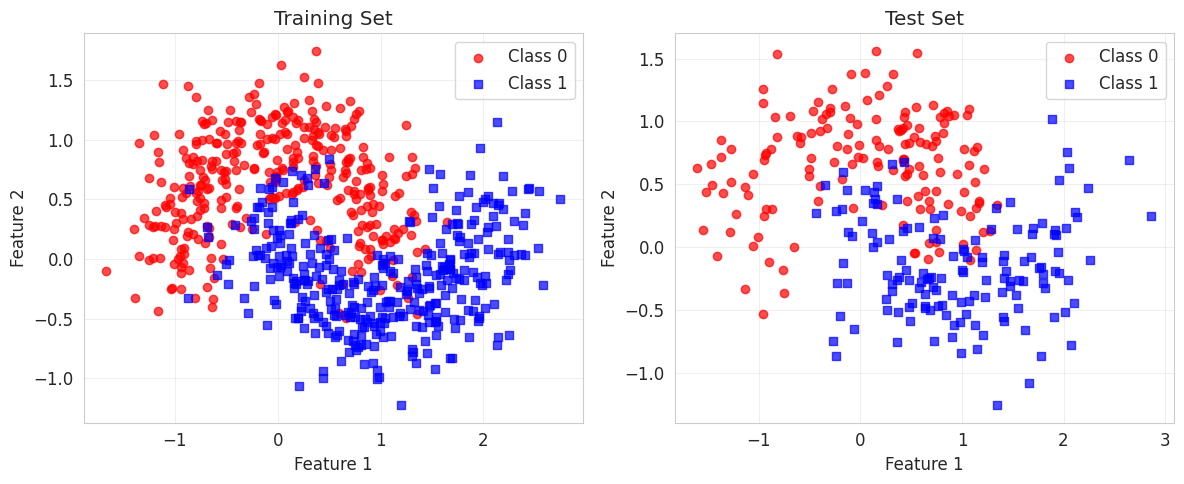

In [47]:
# Create a dataset for demonstration
print("=== VOTING CLASSIFIERS DEMONSTRATION ===")
print("\nCreating moon-shaped dataset for binary classification...")

# Generate moons dataset
X, y = make_moons(n_samples=1000, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Visualize the dataset
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='red', marker='o', alpha=0.7, label='Class 0')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='blue', marker='s', alpha=0.7, label='Class 1')
plt.title('Training Set')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], c='red', marker='o', alpha=0.7, label='Class 0')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], c='blue', marker='s', alpha=0.7, label='Class 1')
plt.title('Test Set')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [48]:
# Create diverse individual classifiers
print("\n=== TRAINING INDIVIDUAL CLASSIFIERS ===")

# Initialize classifiers with different algorithms
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(probability=True, random_state=42)  # probability=True for soft voting

classifiers = [log_clf, rnd_clf, svm_clf]
classifier_names = ['Logistic Regression', 'Random Forest', 'SVM']

# Train and evaluate individual classifiers
individual_scores = []

for clf, name in zip(classifiers, classifier_names):
    print(f"\nTraining {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    individual_scores.append(score)
    print(f"{name} Accuracy: {score:.4f}")

    # Cross-validation score
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(f"{name} CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

print(f"\nAverage individual accuracy: {np.mean(individual_scores):.4f}")


=== TRAINING INDIVIDUAL CLASSIFIERS ===

Training Logistic Regression...
Logistic Regression Accuracy: 0.8533
Logistic Regression CV Score: 0.8514 (+/- 0.0560)

Training Random Forest...
Random Forest Accuracy: 0.9133
Random Forest CV Score: 0.9057 (+/- 0.0210)

Training SVM...
SVM Accuracy: 0.9167
SVM CV Score: 0.9129 (+/- 0.0522)

Average individual accuracy: 0.8944



=== TRAINING VOTING CLASSIFIERS ===

Training Hard Voting Classifier...
Hard Voting Accuracy: 0.9133

Training Soft Voting Classifier...
Soft Voting Accuracy: 0.9133

=== COMPARISON OF ALL METHODS ===
Logistic Regression : 0.8533
Random Forest       : 0.9133
SVM                 : 0.9167
Hard Voting         : 0.9133
Soft Voting         : 0.9133


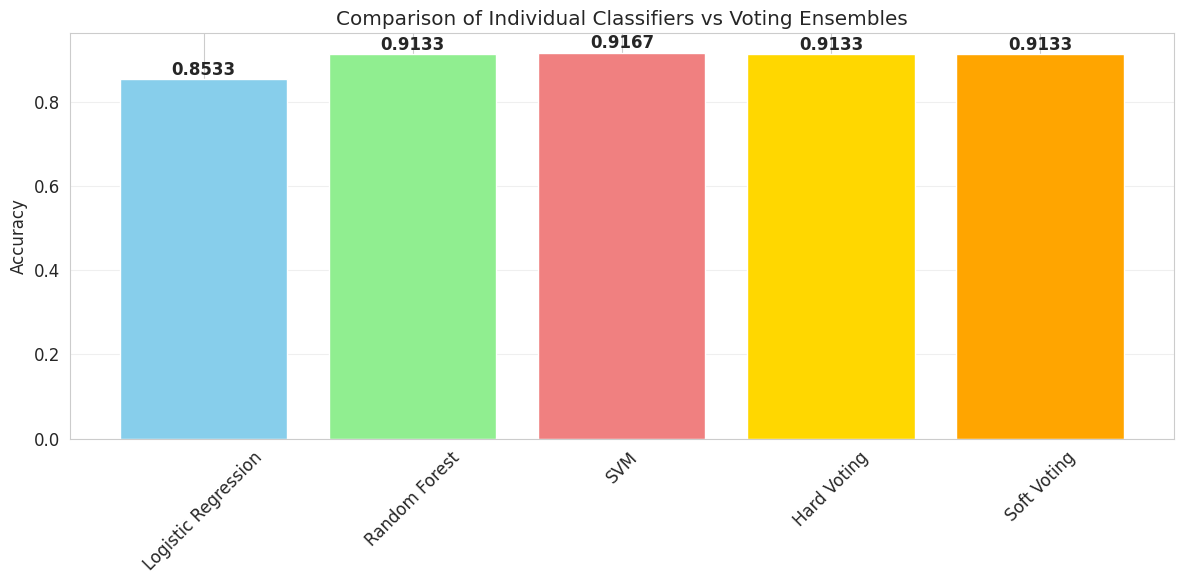


=== IMPROVEMENT ANALYSIS ===
Best individual classifier accuracy: 0.9167
Hard voting improvement: -0.33 percentage points
Soft voting improvement: -0.33 percentage points


In [49]:
# Create and train voting classifiers
print("\n=== TRAINING VOTING CLASSIFIERS ===")

# Hard Voting Classifier
print("\nTraining Hard Voting Classifier...")
voting_clf_hard = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)

voting_clf_hard.fit(X_train, y_train)
y_pred_hard = voting_clf_hard.predict(X_test)
hard_score = accuracy_score(y_test, y_pred_hard)

print(f"Hard Voting Accuracy: {hard_score:.4f}")

# Soft Voting Classifier
print("\nTraining Soft Voting Classifier...")
voting_clf_soft = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'
)

voting_clf_soft.fit(X_train, y_train)
y_pred_soft = voting_clf_soft.predict(X_test)
soft_score = accuracy_score(y_test, y_pred_soft)

print(f"Soft Voting Accuracy: {soft_score:.4f}")

# Compare all methods
print("\n=== COMPARISON OF ALL METHODS ===")
results = {
    'Logistic Regression': individual_scores[0],
    'Random Forest': individual_scores[1],
    'SVM': individual_scores[2],
    'Hard Voting': hard_score,
    'Soft Voting': soft_score
}

for method, score in results.items():
    print(f"{method:<20}: {score:.4f}")

# Visualize results
methods = list(results.keys())
scores = list(results.values())

plt.figure(figsize=(12, 6))
bars = plt.bar(methods, scores, color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'orange'])
plt.ylabel('Accuracy')
plt.title('Comparison of Individual Classifiers vs Voting Ensembles')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Improvement analysis
best_individual = max(individual_scores)
print(f"\n=== IMPROVEMENT ANALYSIS ===")
print(f"Best individual classifier accuracy: {best_individual:.4f}")
print(f"Hard voting improvement: {(hard_score - best_individual)*100:.2f} percentage points")
print(f"Soft voting improvement: {(soft_score - best_individual)*100:.2f} percentage points")

In [50]:
# Analyze prediction probabilities for soft voting
print("\n=== SOFT VOTING PROBABILITY ANALYSIS ===")

# Get prediction probabilities from individual classifiers
log_probs = log_clf.predict_proba(X_test[:5])  # First 5 test samples
rf_probs = rnd_clf.predict_proba(X_test[:5])
svm_probs = svm_clf.predict_proba(X_test[:5])

# Get soft voting probabilities
soft_probs = voting_clf_soft.predict_proba(X_test[:5])

print("Prediction probabilities for first 5 test samples:")
print("\nTrue labels:", y_test[:5])

for i in range(5):
    print(f"\nSample {i+1}:")
    print(f"  Logistic Regression: [{log_probs[i][0]:.3f}, {log_probs[i][1]:.3f}]")
    print(f"  Random Forest:       [{rf_probs[i][0]:.3f}, {rf_probs[i][1]:.3f}]")
    print(f"  SVM:                 [{svm_probs[i][0]:.3f}, {svm_probs[i][1]:.3f}]")
    print(f"  Soft Voting (avg):   [{soft_probs[i][0]:.3f}, {soft_probs[i][1]:.3f}]")

    # Verify that soft voting is the average
    manual_avg = (log_probs[i] + rf_probs[i] + svm_probs[i]) / 3
    print(f"  Manual average:      [{manual_avg[0]:.3f}, {manual_avg[1]:.3f}]")

    # Show predictions
    hard_votes = [log_clf.predict([X_test[i]])[0],
                  rnd_clf.predict([X_test[i]])[0],
                  svm_clf.predict([X_test[i]])[0]]
    hard_prediction = 1 if sum(hard_votes) >= 2 else 0
    soft_prediction = 1 if soft_probs[i][1] > 0.5 else 0

    print(f"  Individual votes: {hard_votes} → Hard voting: {hard_prediction}")
    print(f"  Soft voting prediction: {soft_prediction}")


=== SOFT VOTING PROBABILITY ANALYSIS ===
Prediction probabilities for first 5 test samples:

True labels: [1 0 1 0 1]

Sample 1:
  Logistic Regression: [0.063, 0.937]
  Random Forest:       [0.030, 0.970]
  SVM:                 [0.029, 0.971]
  Soft Voting (avg):   [0.041, 0.959]
  Manual average:      [0.041, 0.959]
  Individual votes: [np.int64(1), np.int64(1), np.int64(1)] → Hard voting: 1
  Soft voting prediction: 1

Sample 2:
  Logistic Regression: [0.319, 0.681]
  Random Forest:       [0.810, 0.190]
  SVM:                 [0.719, 0.281]
  Soft Voting (avg):   [0.616, 0.384]
  Manual average:      [0.616, 0.384]
  Individual votes: [np.int64(1), np.int64(0), np.int64(0)] → Hard voting: 0
  Soft voting prediction: 0

Sample 3:
  Logistic Regression: [0.045, 0.955]
  Random Forest:       [0.000, 1.000]
  SVM:                 [0.039, 0.961]
  Soft Voting (avg):   [0.028, 0.972]
  Manual average:      [0.028, 0.972]
  Individual votes: [np.int64(1), np.int64(1), np.int64(1)] → Hard v

# 3. Bagging and Pasting

## Theory

**Bagging** (Bootstrap Aggregating) and **Pasting** train multiple predictors on different random subsets of the training set.

### Key Differences:
- **Bagging**: Sampling with replacement (bootstrap)
- **Pasting**: Sampling without replacement

### Mathematical Foundation

**Bootstrap Sampling:**
For a training set of size $m$, each bootstrap sample:
- Contains approximately $63.2\%$ unique instances
- Leaves approximately $36.8\%$ as out-of-bag (OOB) instances

**Probability calculation:**
$$P(\text{instance not selected}) = \left(1 - \frac{1}{m}\right)^m \approx e^{-1} \approx 0.368$$

**Bias-Variance Trade-off:**
- Individual predictors have higher bias but lower variance
- Aggregation reduces both bias and variance
- Net result: similar bias, lower variance than single predictor

### Out-of-Bag (OOB) Evaluation

**OOB Score:** Each predictor can be evaluated on instances it never saw during training, providing an unbiased estimate without needing a separate validation set.

=== BOOTSTRAP SAMPLING DEMONSTRATION ===


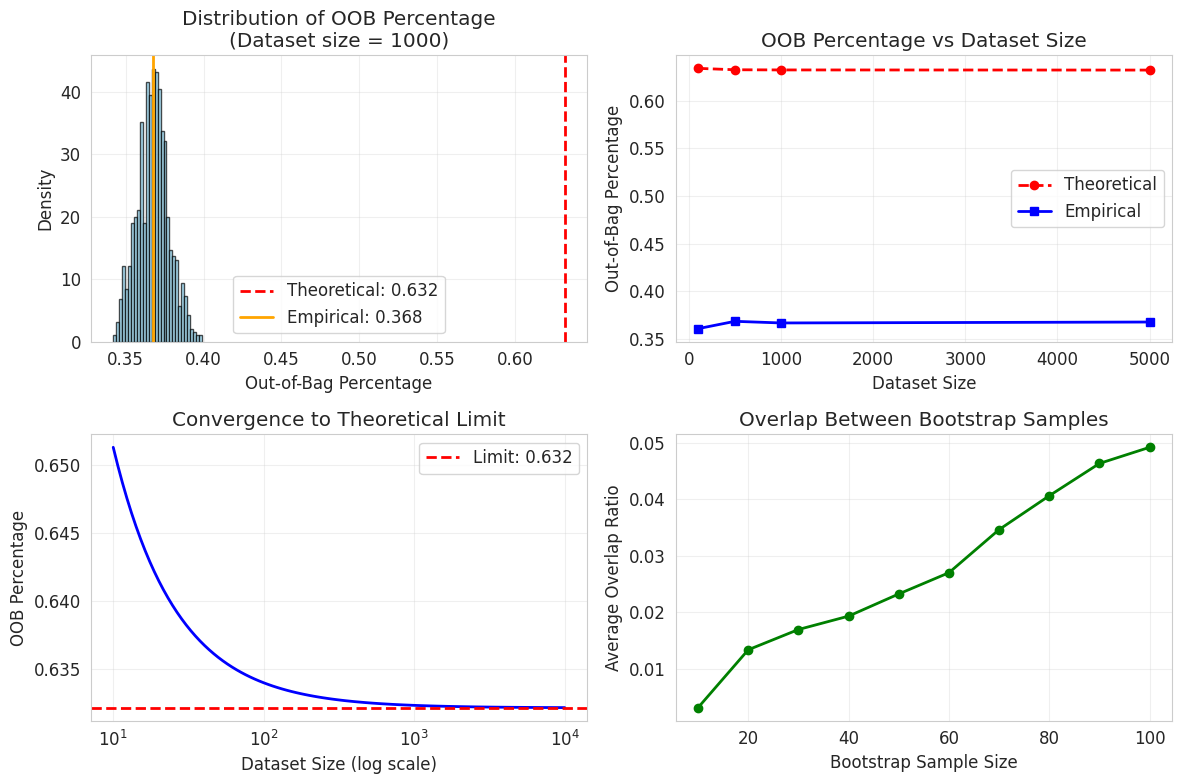


Bootstrap Sampling Analysis:
Theoretical OOB percentage: 0.6321 (63.2%)
Empirical OOB percentage: 0.3677 (36.8%)
Standard deviation: 0.0101


In [51]:
# Demonstrate bootstrap sampling characteristics
print("=== BOOTSTRAP SAMPLING DEMONSTRATION ===")

def analyze_bootstrap_sampling(dataset_size, num_samples=1000):
    """
    Analyze the characteristics of bootstrap sampling.
    Shows the theoretical vs empirical out-of-bag percentage.
    """
    oob_percentages = []

    for _ in range(num_samples):
        # Create a bootstrap sample
        bootstrap_indices = np.random.choice(dataset_size, size=dataset_size, replace=True)
        unique_indices = set(bootstrap_indices)
        oob_count = dataset_size - len(unique_indices)
        oob_percentage = oob_count / dataset_size
        oob_percentages.append(oob_percentage)

    return np.array(oob_percentages)

# Test with different dataset sizes
dataset_sizes = [100, 500, 1000, 5000]
theoretical_oob = 1 - (1 - 1/np.array(dataset_sizes))**np.array(dataset_sizes)

plt.figure(figsize=(12, 8))

# Plot 1: OOB percentage distribution
plt.subplot(2, 2, 1)
oob_percentages = analyze_bootstrap_sampling(1000)
plt.hist(oob_percentages, bins=30, alpha=0.7, density=True, color='skyblue', edgecolor='black')
plt.axvline(x=1-np.exp(-1), color='red', linestyle='--', linewidth=2,
            label=f'Theoretical: {1-np.exp(-1):.3f}')
plt.axvline(x=np.mean(oob_percentages), color='orange', linestyle='-', linewidth=2,
            label=f'Empirical: {np.mean(oob_percentages):.3f}')
plt.xlabel('Out-of-Bag Percentage')
plt.ylabel('Density')
plt.title('Distribution of OOB Percentage\n(Dataset size = 1000)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: OOB vs dataset size
plt.subplot(2, 2, 2)
empirical_oob = []
for size in dataset_sizes:
    oob_pct = analyze_bootstrap_sampling(size, 100)
    empirical_oob.append(np.mean(oob_pct))

plt.plot(dataset_sizes, theoretical_oob, 'r--', linewidth=2, marker='o', label='Theoretical')
plt.plot(dataset_sizes, empirical_oob, 'b-', linewidth=2, marker='s', label='Empirical')
plt.xlabel('Dataset Size')
plt.ylabel('Out-of-Bag Percentage')
plt.title('OOB Percentage vs Dataset Size')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Convergence to theoretical limit
plt.subplot(2, 2, 3)
sizes = np.logspace(1, 4, 100)  # From 10 to 10,000
theoretical_curve = 1 - (1 - 1/sizes)**sizes
plt.semilogx(sizes, theoretical_curve, 'b-', linewidth=2)
plt.axhline(y=1-np.exp(-1), color='red', linestyle='--', linewidth=2,
            label=f'Limit: {1-np.exp(-1):.3f}')
plt.xlabel('Dataset Size (log scale)')
plt.ylabel('OOB Percentage')
plt.title('Convergence to Theoretical Limit')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Sample overlap analysis
plt.subplot(2, 2, 4)
sample_sizes = np.arange(10, 101, 10)
overlap_percentages = []

for size in sample_sizes:
    overlaps = []
    for _ in range(100):
        sample1 = set(np.random.choice(1000, size=size, replace=True))
        sample2 = set(np.random.choice(1000, size=size, replace=True))
        overlap = len(sample1.intersection(sample2)) / len(sample1.union(sample2))
        overlaps.append(overlap)
    overlap_percentages.append(np.mean(overlaps))

plt.plot(sample_sizes, overlap_percentages, 'g-', linewidth=2, marker='o')
plt.xlabel('Bootstrap Sample Size')
plt.ylabel('Average Overlap Ratio')
plt.title('Overlap Between Bootstrap Samples')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBootstrap Sampling Analysis:")
print(f"Theoretical OOB percentage: {1-np.exp(-1):.4f} ({100*(1-np.exp(-1)):.1f}%)")
print(f"Empirical OOB percentage: {np.mean(oob_percentages):.4f} ({100*np.mean(oob_percentages):.1f}%)")
print(f"Standard deviation: {np.std(oob_percentages):.4f}")


=== BAGGING VS PASTING COMPARISON ===
Using moons dataset: 700 training samples

Training Bagging Classifier...
Bagging Classifier Accuracy: 0.9000

Training Pasting Classifier...
Pasting Classifier Accuracy: 0.9133

Training Single Decision Tree...
Single Decision Tree Accuracy: 0.8933

=== COMPARISON ===
Single Decision Tree     : 0.8933
Bagging (500 trees)      : 0.9000
Pasting (500 trees)      : 0.9133


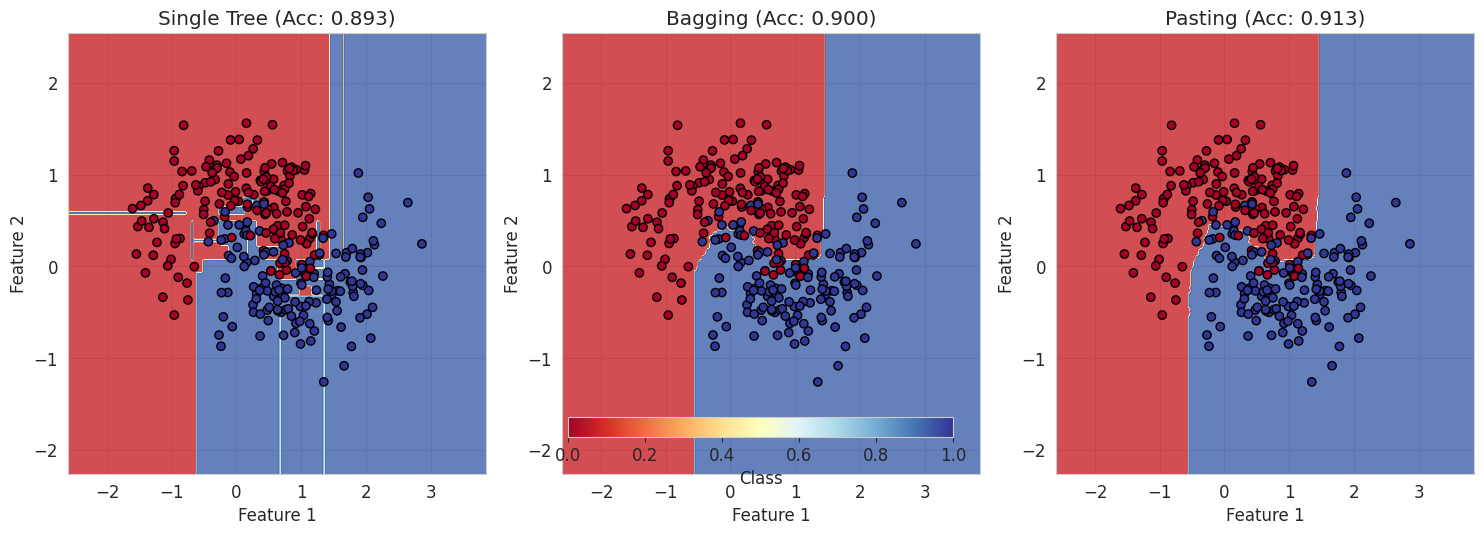


Observations:
- Bagging improvement over single tree: 0.67 percentage points
- Pasting improvement over single tree: 2.00 percentage points
- Difference between Bagging and Pasting: 1.33 percentage points


In [33]:
# Implement and compare Bagging vs Pasting
print("\n=== BAGGING VS PASTING COMPARISON ===")

# Use the moons dataset from before
print(f"Using moons dataset: {X_train.shape[0]} training samples")

# Bagging Classifier (with replacement)
print("\nTraining Bagging Classifier...")
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    max_samples=100,  # Sample 100 instances per tree
    bootstrap=True,   # Sampling with replacement (bagging)
    n_jobs=-1,        # Use all CPU cores
    random_state=42
)

bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
bag_score = accuracy_score(y_test, y_pred_bag)

print(f"Bagging Classifier Accuracy: {bag_score:.4f}")

# Pasting Classifier (without replacement)
print("\nTraining Pasting Classifier...")
paste_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    max_samples=100,
    bootstrap=False,  # Sampling without replacement (pasting)
    n_jobs=-1,
    random_state=42
)

paste_clf.fit(X_train, y_train)
y_pred_paste = paste_clf.predict(X_test)
paste_score = accuracy_score(y_test, y_pred_paste)

print(f"Pasting Classifier Accuracy: {paste_score:.4f}")

# Single Decision Tree for comparison
print("\nTraining Single Decision Tree...")
single_tree = DecisionTreeClassifier(random_state=42)
single_tree.fit(X_train, y_train)
y_pred_single = single_tree.predict(X_test)
single_score = accuracy_score(y_test, y_pred_single)

print(f"Single Decision Tree Accuracy: {single_score:.4f}")

# Compare results
print("\n=== COMPARISON ===")
ensemble_results = {
    'Single Decision Tree': single_score,
    'Bagging (500 trees)': bag_score,
    'Pasting (500 trees)': paste_score
}

for method, score in ensemble_results.items():
    print(f"{method:<25}: {score:.4f}")

# Visualize decision boundaries
def plot_decision_boundary(clf, X, y, title, subplot_pos):
    plt.subplot(subplot_pos)

    # Create a mesh
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Make predictions on mesh
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)

    # Plot data points
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)

    return scatter

plt.figure(figsize=(15, 5))

# Plot decision boundaries
plot_decision_boundary(single_tree, X_test, y_test,
                      f'Single Tree (Acc: {single_score:.3f})', 131)
plot_decision_boundary(bag_clf, X_test, y_test,
                      f'Bagging (Acc: {bag_score:.3f})', 132)
scatter = plot_decision_boundary(paste_clf, X_test, y_test,
                                f'Pasting (Acc: {paste_score:.3f})', 133)

# Add colorbar
plt.colorbar(scatter, ax=plt.gcf().get_axes(), orientation='horizontal',
             fraction=0.05, pad=0.1, label='Class')

plt.tight_layout()
plt.show()

print(f"\nObservations:")
print(f"- Bagging improvement over single tree: {(bag_score - single_score)*100:.2f} percentage points")
print(f"- Pasting improvement over single tree: {(paste_score - single_score)*100:.2f} percentage points")
print(f"- Difference between Bagging and Pasting: {abs(bag_score - paste_score)*100:.2f} percentage points")


=== OUT-OF-BAG (OOB) EVALUATION ===
Training Bagging Classifier with OOB evaluation...

OOB Score: 0.8971
Test Score: 0.9300
Difference: 0.0329

=== OOB DECISION FUNCTION ANALYSIS ===
OOB decision function shape: (700, 2)
Training set size: 700

First 10 OOB probability predictions:
[Class 0 Prob, Class 1 Prob]
Sample 1: [1.000, 0.000] → Pred: 0, Actual: 0 ✓
Sample 2: [1.000, 0.000] → Pred: 0, Actual: 0 ✓
Sample 3: [0.021, 0.979] → Pred: 1, Actual: 0 ✗
Sample 4: [1.000, 0.000] → Pred: 0, Actual: 0 ✓
Sample 5: [0.011, 0.989] → Pred: 1, Actual: 0 ✗
Sample 6: [0.110, 0.890] → Pred: 1, Actual: 1 ✓
Sample 7: [0.012, 0.988] → Pred: 1, Actual: 0 ✗
Sample 8: [1.000, 0.000] → Pred: 0, Actual: 0 ✓
Sample 9: [0.981, 0.019] → Pred: 0, Actual: 0 ✓
Sample 10: [0.495, 0.505] → Pred: 1, Actual: 0 ✗

=== OOB vs CROSS-VALIDATION COMPARISON ===
OOB Score: 0.8971
CV Score: 0.9000 (+/- 0.0373)

OOB provides validation without additional computation!
OOB is computed during training, CV requires additional 

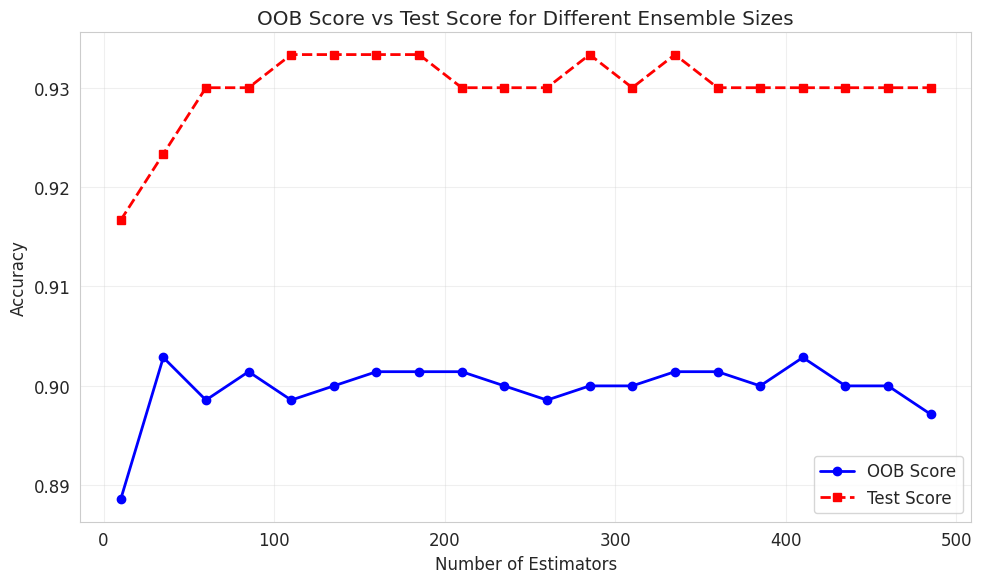

Optimal number of estimators (based on OOB): 35
OOB score at optimum: 0.9029
Test score at optimum: 0.9233
Correlation between OOB and test scores: 0.6398


In [34]:
# Out-of-Bag Evaluation
print("\n=== OUT-OF-BAG (OOB) EVALUATION ===")

# Create bagging classifier with OOB evaluation
print("Training Bagging Classifier with OOB evaluation...")
bag_clf_oob = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    bootstrap=True,
    oob_score=True,  # Enable OOB evaluation
    n_jobs=-1,
    random_state=42
)

bag_clf_oob.fit(X_train, y_train)

# Get OOB score and test score
oob_score = bag_clf_oob.oob_score_
test_score = bag_clf_oob.score(X_test, y_test)

print(f"\nOOB Score: {oob_score:.4f}")
print(f"Test Score: {test_score:.4f}")
print(f"Difference: {abs(oob_score - test_score):.4f}")

# Analyze OOB decision function
print("\n=== OOB DECISION FUNCTION ANALYSIS ===")

# Get OOB decision function (class probabilities)
oob_decision = bag_clf_oob.oob_decision_function_

print(f"OOB decision function shape: {oob_decision.shape}")
print(f"Training set size: {X_train.shape[0]}")

# Show first few OOB predictions
print("\nFirst 10 OOB probability predictions:")
print("[Class 0 Prob, Class 1 Prob]")
for i in range(10):
    prob_class_0 = oob_decision[i, 0]
    prob_class_1 = oob_decision[i, 1]
    predicted_class = 1 if prob_class_1 > prob_class_0 else 0
    actual_class = y_train[i]
    correct = "✓" if predicted_class == actual_class else "✗"

    print(f"Sample {i+1}: [{prob_class_0:.3f}, {prob_class_1:.3f}] → Pred: {predicted_class}, Actual: {actual_class} {correct}")

# Compare OOB vs Cross-Validation
print("\n=== OOB vs CROSS-VALIDATION COMPARISON ===")

# Cross-validation score
cv_scores = cross_val_score(bag_clf_oob, X_train, y_train, cv=5)
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print(f"OOB Score: {oob_score:.4f}")
print(f"CV Score: {cv_mean:.4f} (+/- {cv_std * 2:.4f})")
print(f"\nOOB provides validation without additional computation!")
print(f"OOB is computed during training, CV requires additional model training.")

# Visualize OOB vs number of estimators
print("\n=== OOB SCORE vs NUMBER OF ESTIMATORS ===")

estimator_range = range(10, 501, 25)
oob_scores = []
test_scores = []

for n_est in estimator_range:
    clf = BaggingClassifier(
        DecisionTreeClassifier(random_state=42),
        n_estimators=n_est,
        bootstrap=True,
        oob_score=True,
        n_jobs=-1,
        random_state=42
    )
    clf.fit(X_train, y_train)
    oob_scores.append(clf.oob_score_)
    test_scores.append(clf.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(estimator_range, oob_scores, 'b-', linewidth=2, label='OOB Score', marker='o')
plt.plot(estimator_range, test_scores, 'r--', linewidth=2, label='Test Score', marker='s')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('OOB Score vs Test Score for Different Ensemble Sizes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find optimal number of estimators
optimal_idx = np.argmax(oob_scores)
optimal_estimators = estimator_range[optimal_idx]
optimal_oob_score = oob_scores[optimal_idx]
optimal_test_score = test_scores[optimal_idx]

print(f"Optimal number of estimators (based on OOB): {optimal_estimators}")
print(f"OOB score at optimum: {optimal_oob_score:.4f}")
print(f"Test score at optimum: {optimal_test_score:.4f}")
print(f"Correlation between OOB and test scores: {np.corrcoef(oob_scores, test_scores)[0,1]:.4f}")

# 4. Random Forests and Extra-Trees

## Theory

**Random Forests** combine bagging with random feature selection at each split.

### Algorithm:
1. Create bootstrap samples of the training data
2. For each tree, at each node:
   - Randomly select $\sqrt{n}$ features (for classification) or $n/3$ features (for regression)
   - Find the best split among these features only
3. Aggregate predictions by majority vote (classification) or averaging (regression)

### Mathematical Foundation

**Feature Importance:**
$$\text{Importance}(f) = \frac{1}{N} \sum_{t=1}^{N} \sum_{n \in t} w_n \cdot \Delta I(n, f)$$

Where:
- $N$ = number of trees
- $w_n$ = weighted number of samples reaching node $n$
- $\Delta I(n, f)$ = impurity decrease when splitting on feature $f$ at node $n$

### Extra-Trees (Extremely Randomized Trees)

**Additional Randomness:**
- Random thresholds for each feature (instead of optimal thresholds)
- Even more regularization
- Faster training but potentially lower accuracy

**Bias-Variance Trade-off:**
- Extra-Trees: Higher bias, lower variance
- Random Forests: Lower bias, higher variance

=== RANDOM FORESTS vs EXTRA-TREES COMPARISON ===

Loading Iris dataset for feature importance analysis...
Iris dataset shape: (150, 4)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Classes: ['setosa' 'versicolor' 'virginica']

Training Random Forest Classifier...
Random Forest Accuracy: 0.9111

Training Extra-Trees Classifier...
Extra-Trees Accuracy: 0.9111

Training Single Decision Tree...
Decision Tree Accuracy: 0.9333

=== FEATURE IMPORTANCE ANALYSIS ===

Feature Importances:
Feature              Random Forest   Extra-Trees     Decision Tree  
----------------------------------------------------------------------
sepal length (cm)    0.1208          0.0979          0.0000         
sepal width (cm)     0.0279          0.0500          0.0286         
petal length (cm)    0.4179          0.4082          0.5412         
petal width (cm)     0.4334          0.4439          0.4303         


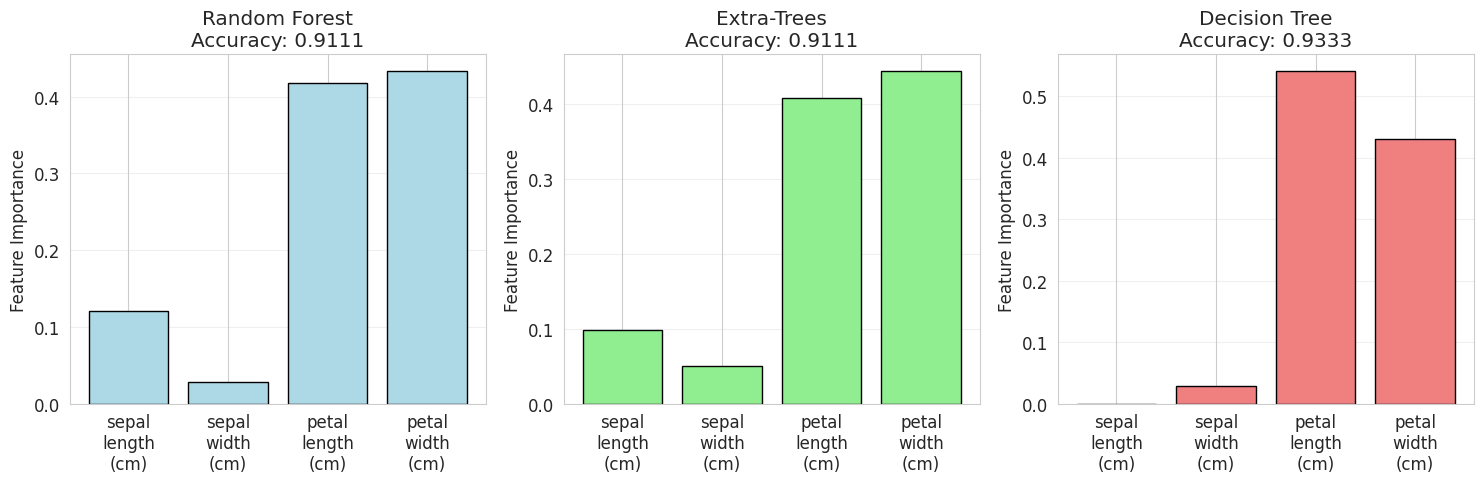


=== STABILITY ANALYSIS ===
Random Forest - Mean accuracy: 0.9000, Std: 0.0111
Extra-Trees - Mean accuracy: 0.9089, Std: 0.0156

Feature importance stability (standard deviation):
sepal length (cm)   : RF std = 0.0160, ET std = 0.0117
sepal width (cm)    : RF std = 0.0042, ET std = 0.0045
petal length (cm)   : RF std = 0.0291, ET std = 0.0209
petal width (cm)    : RF std = 0.0302, ET std = 0.0160


In [35]:
# Random Forest vs Extra-Trees Comparison
print("=== RANDOM FORESTS vs EXTRA-TREES COMPARISON ===")

# Load Iris dataset for feature importance analysis
print("\nLoading Iris dataset for feature importance analysis...")
iris = load_iris()
X_iris, y_iris = iris.data, iris.target
feature_names = iris.feature_names

# Split the data
X_iris_train, X_iris_test, y_iris_train, y_iris_test = train_test_split(
    X_iris, y_iris, test_size=0.3, random_state=42, stratify=y_iris
)

print(f"Iris dataset shape: {X_iris.shape}")
print(f"Features: {feature_names}")
print(f"Classes: {iris.target_names}")

# Train Random Forest
print("\nTraining Random Forest Classifier...")
rf_clf = RandomForestClassifier(
    n_estimators=500,
    max_features='sqrt',  # sqrt(n_features) for classification
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_iris_train, y_iris_train)
rf_score = rf_clf.score(X_iris_test, y_iris_test)
print(f"Random Forest Accuracy: {rf_score:.4f}")

# Train Extra-Trees
print("\nTraining Extra-Trees Classifier...")
et_clf = ExtraTreesClassifier(
    n_estimators=500,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

et_clf.fit(X_iris_train, y_iris_train)
et_score = et_clf.score(X_iris_test, y_iris_test)
print(f"Extra-Trees Accuracy: {et_score:.4f}")

# Compare with individual Decision Tree
print("\nTraining Single Decision Tree...")
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_iris_train, y_iris_train)
dt_score = dt_clf.score(X_iris_test, y_iris_test)
print(f"Decision Tree Accuracy: {dt_score:.4f}")

# Feature Importance Analysis
print("\n=== FEATURE IMPORTANCE ANALYSIS ===")

rf_importances = rf_clf.feature_importances_
et_importances = et_clf.feature_importances_
dt_importances = dt_clf.feature_importances_

print("\nFeature Importances:")
print(f"{'Feature':<20} {'Random Forest':<15} {'Extra-Trees':<15} {'Decision Tree':<15}")
print("-" * 70)

for i, feature in enumerate(feature_names):
    print(f"{feature:<20} {rf_importances[i]:<15.4f} {et_importances[i]:<15.4f} {dt_importances[i]:<15.4f}")

# Visualize feature importances
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Random Forest importances
axes[0].bar(range(len(feature_names)), rf_importances, color='lightblue', edgecolor='black')
axes[0].set_title(f'Random Forest\nAccuracy: {rf_score:.4f}')
axes[0].set_ylabel('Feature Importance')
axes[0].set_xticks(range(len(feature_names)))
axes[0].set_xticklabels([name.replace(' ', '\n') for name in feature_names], rotation=0)
axes[0].grid(True, alpha=0.3, axis='y')

# Extra-Trees importances
axes[1].bar(range(len(feature_names)), et_importances, color='lightgreen', edgecolor='black')
axes[1].set_title(f'Extra-Trees\nAccuracy: {et_score:.4f}')
axes[1].set_ylabel('Feature Importance')
axes[1].set_xticks(range(len(feature_names)))
axes[1].set_xticklabels([name.replace(' ', '\n') for name in feature_names], rotation=0)
axes[1].grid(True, alpha=0.3, axis='y')

# Decision Tree importances
axes[2].bar(range(len(feature_names)), dt_importances, color='lightcoral', edgecolor='black')
axes[2].set_title(f'Decision Tree\nAccuracy: {dt_score:.4f}')
axes[2].set_ylabel('Feature Importance')
axes[2].set_xticks(range(len(feature_names)))
axes[2].set_xticklabels([name.replace(' ', '\n') for name in feature_names], rotation=0)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Analysis of randomness and stability
print("\n=== STABILITY ANALYSIS ===")

# Train multiple models with different random states
num_trials = 10
rf_scores = []
et_scores = []
rf_importance_vars = []
et_importance_vars = []

for trial in range(num_trials):
    # Random Forest
    rf_temp = RandomForestClassifier(n_estimators=100, random_state=trial)
    rf_temp.fit(X_iris_train, y_iris_train)
    rf_scores.append(rf_temp.score(X_iris_test, y_iris_test))
    rf_importance_vars.append(rf_temp.feature_importances_)

    # Extra-Trees
    et_temp = ExtraTreesClassifier(n_estimators=100, random_state=trial)
    et_temp.fit(X_iris_train, y_iris_train)
    et_scores.append(et_temp.score(X_iris_test, y_iris_test))
    et_importance_vars.append(et_temp.feature_importances_)

rf_scores = np.array(rf_scores)
et_scores = np.array(et_scores)
rf_importance_vars = np.array(rf_importance_vars)
et_importance_vars = np.array(et_importance_vars)

print(f"Random Forest - Mean accuracy: {rf_scores.mean():.4f}, Std: {rf_scores.std():.4f}")
print(f"Extra-Trees - Mean accuracy: {et_scores.mean():.4f}, Std: {et_scores.std():.4f}")

print(f"\nFeature importance stability (standard deviation):")
for i, feature in enumerate(feature_names):
    rf_std = rf_importance_vars[:, i].std()
    et_std = et_importance_vars[:, i].std()
    print(f"{feature:<20}: RF std = {rf_std:.4f}, ET std = {et_std:.4f}")


=== RANDOM FOREST HYPERPARAMETER ANALYSIS ===
Analyzing Random Forest hyperparameters on moons dataset...

Testing different max_features values:
max_features=1      (n=1): Accuracy = 0.9133
max_features=2      (n=2): Accuracy = 0.9267
max_features=sqrt   (n=1): Accuracy = 0.9133
max_features=log2   (n=1): Accuracy = 0.9133
max_features=None   (n=2): Accuracy = 0.9267

Testing different n_estimators values:
n_estimators=1   : Accuracy = 0.8933, Time = 0.005s
n_estimators=5   : Accuracy = 0.8933, Time = 0.017s
n_estimators=10  : Accuracy = 0.9200, Time = 0.031s
n_estimators=25  : Accuracy = 0.9200, Time = 0.070s
n_estimators=50  : Accuracy = 0.9200, Time = 0.169s
n_estimators=100 : Accuracy = 0.9133, Time = 0.289s
n_estimators=200 : Accuracy = 0.9167, Time = 0.580s
n_estimators=500 : Accuracy = 0.9133, Time = 1.717s


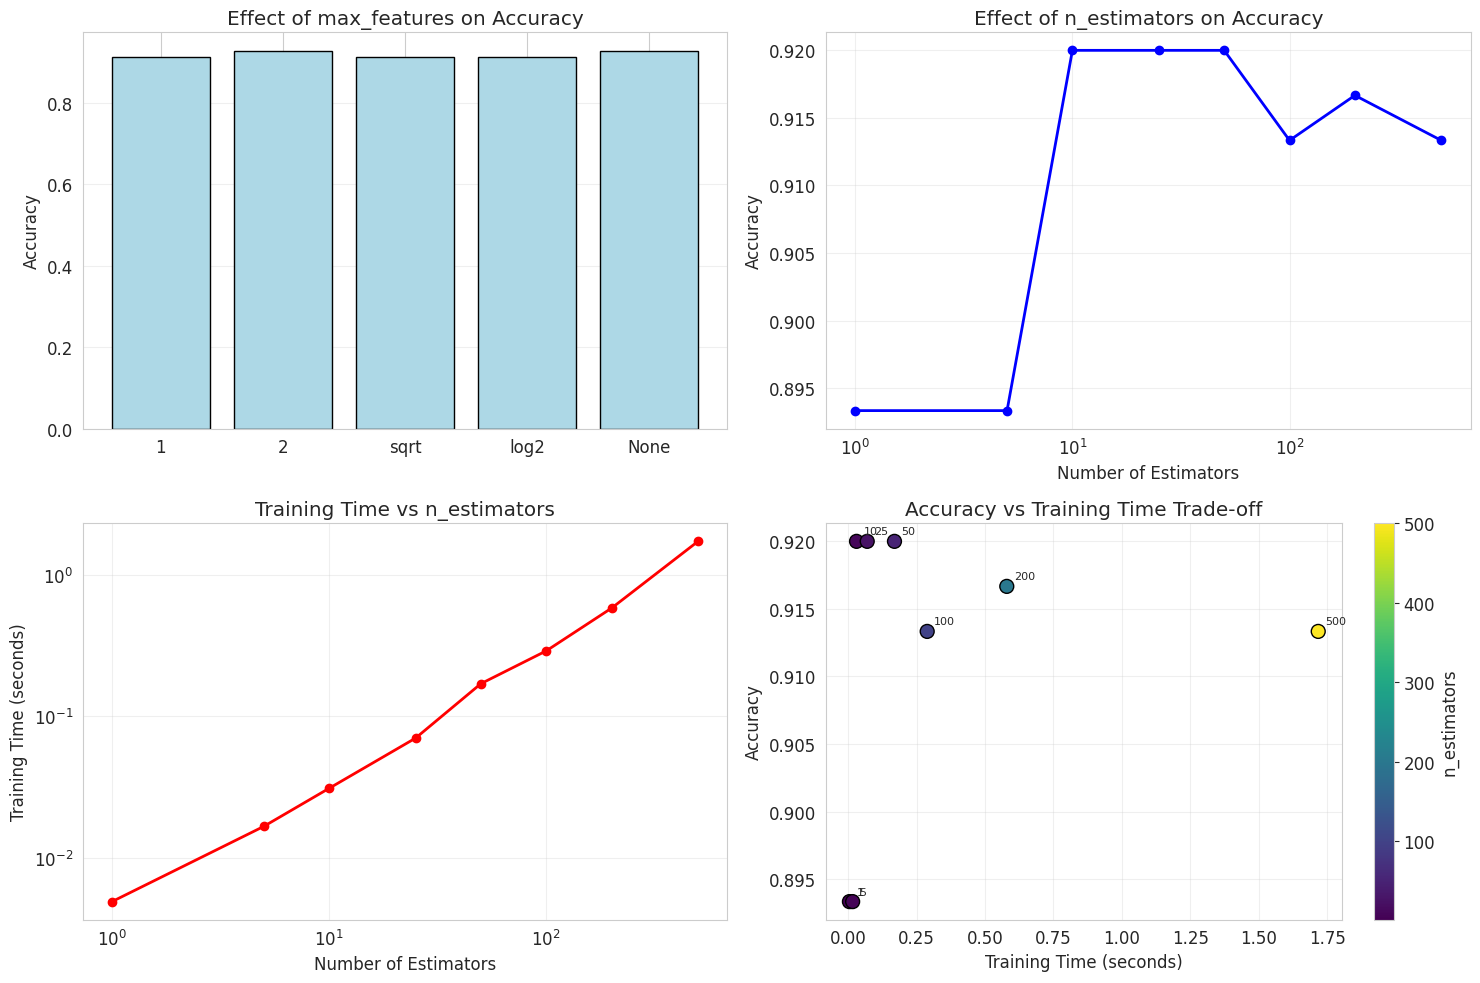


=== OPTIMAL PARAMETERS ===
Best max_features: 2 (Accuracy: 0.9267)
Best n_estimators: 10 (Accuracy: 0.9200)
Most efficient n_estimators: 1 (Accuracy/Time: 183.06)


In [36]:
# Random Forest on Moons Dataset with Hyperparameter Analysis
print("\n=== RANDOM FOREST HYPERPARAMETER ANALYSIS ===")

# Using the moons dataset for visualization
print("Analyzing Random Forest hyperparameters on moons dataset...")

# Effect of max_features
max_features_options = [1, 2, 'sqrt', 'log2', None]
rf_scores_features = []

print("\nTesting different max_features values:")
for max_feat in max_features_options:
    rf_temp = RandomForestClassifier(
        n_estimators=100,
        max_features=max_feat,
        random_state=42
    )
    rf_temp.fit(X_train, y_train)
    score = rf_temp.score(X_test, y_test)
    rf_scores_features.append(score)

    # Calculate actual number of features used
    if max_feat == 'sqrt':
        n_features = int(np.sqrt(X_train.shape[1]))
    elif max_feat == 'log2':
        n_features = int(np.log2(X_train.shape[1]))
    elif max_feat is None:
        n_features = X_train.shape[1]
    else:
        n_features = max_feat

    print(f"max_features={str(max_feat):<6} (n={n_features}): Accuracy = {score:.4f}")

# Effect of n_estimators
n_estimators_range = [1, 5, 10, 25, 50, 100, 200, 500]
rf_scores_estimators = []
training_times = []

print("\nTesting different n_estimators values:")
import time

for n_est in n_estimators_range:
    start_time = time.time()
    rf_temp = RandomForestClassifier(
        n_estimators=n_est,
        max_features='sqrt',
        random_state=42
    )
    rf_temp.fit(X_train, y_train)
    train_time = time.time() - start_time

    score = rf_temp.score(X_test, y_test)
    rf_scores_estimators.append(score)
    training_times.append(train_time)

    print(f"n_estimators={n_est:<4}: Accuracy = {score:.4f}, Time = {train_time:.3f}s")

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: max_features effect
axes[0, 0].bar(range(len(max_features_options)), rf_scores_features,
               color='lightblue', edgecolor='black')
axes[0, 0].set_title('Effect of max_features on Accuracy')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_xticks(range(len(max_features_options)))
axes[0, 0].set_xticklabels([str(x) for x in max_features_options])
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Plot 2: n_estimators effect on accuracy
axes[0, 1].plot(n_estimators_range, rf_scores_estimators, 'bo-', linewidth=2, markersize=6)
axes[0, 1].set_title('Effect of n_estimators on Accuracy')
axes[0, 1].set_xlabel('Number of Estimators')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xscale('log')

# Plot 3: Training time vs n_estimators
axes[1, 0].plot(n_estimators_range, training_times, 'ro-', linewidth=2, markersize=6)
axes[1, 0].set_title('Training Time vs n_estimators')
axes[1, 0].set_xlabel('Number of Estimators')
axes[1, 0].set_ylabel('Training Time (seconds)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')

# Plot 4: Accuracy vs Training Time trade-off
axes[1, 1].scatter(training_times, rf_scores_estimators, c=n_estimators_range,
                   cmap='viridis', s=100, edgecolors='black')
axes[1, 1].set_title('Accuracy vs Training Time Trade-off')
axes[1, 1].set_xlabel('Training Time (seconds)')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].grid(True, alpha=0.3)

# Add colorbar for the scatter plot
cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
cbar.set_label('n_estimators')

# Annotate points with n_estimators values
for i, n_est in enumerate(n_estimators_range):
    axes[1, 1].annotate(str(n_est), (training_times[i], rf_scores_estimators[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

# Find optimal parameters
best_features_idx = np.argmax(rf_scores_features)
best_estimators_idx = np.argmax(rf_scores_estimators)

print(f"\n=== OPTIMAL PARAMETERS ===")
print(f"Best max_features: {max_features_options[best_features_idx]} (Accuracy: {rf_scores_features[best_features_idx]:.4f})")
print(f"Best n_estimators: {n_estimators_range[best_estimators_idx]} (Accuracy: {rf_scores_estimators[best_estimators_idx]:.4f})")

# Efficiency analysis
efficiency_scores = np.array(rf_scores_estimators) / np.array(training_times)
best_efficiency_idx = np.argmax(efficiency_scores)
print(f"Most efficient n_estimators: {n_estimators_range[best_efficiency_idx]} (Accuracy/Time: {efficiency_scores[best_efficiency_idx]:.2f})")

# 5. Boosting Algorithms

## Theory

**Boosting** trains predictors sequentially, each trying to correct its predecessor's errors.

### AdaBoost (Adaptive Boosting)

**Algorithm:**
1. Initialize instance weights: $w_i^{(1)} = \frac{1}{m}$
2. For each predictor $j$:
   - Train predictor $h_j$ using weighted training set
   - Compute weighted error rate: $r_j = \frac{\sum_{i=1}^{m} w_i^{(j)} \mathbb{1}[h_j(x_i) \neq y_i]}{\sum_{i=1}^{m} w_i^{(j)}}$
   - Compute predictor weight: $\alpha_j = \eta \log\frac{1-r_j}{r_j}$
   - Update instance weights: $w_i^{(j+1)} = w_i^{(j)} \times \begin{cases} 1 & \text{if } h_j(x_i) = y_i \\ \exp(\alpha_j) & \text{if } h_j(x_i) \neq y_i \end{cases}$
   - Normalize weights

**Final Prediction:**
$$h(x) = \text{sign}\left(\sum_{j=1}^{N} \alpha_j h_j(x)\right)$$

### Gradient Boosting

**Algorithm:**
1. Initialize: $F_0(x) = \arg\min_\gamma \sum_{i=1}^{m} L(y_i, \gamma)$
2. For $j = 1$ to $N$:
   - Compute residuals: $r_{ij} = -\left[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\right]_{F=F_{j-1}}$
   - Train predictor $h_j$ to predict residuals
   - Find optimal step size: $\gamma_j = \arg\min_\gamma \sum_{i=1}^{m} L(y_i, F_{j-1}(x_i) + \gamma h_j(x_i))$
   - Update: $F_j(x) = F_{j-1}(x) + \gamma_j h_j(x)$

**For Regression with MSE:**
$$r_{ij} = y_i - F_{j-1}(x_i)$$

=== ADABOOST DEMONSTRATION ===
Creating challenging dataset for AdaBoost...

Training AdaBoost with Decision Stumps...
AdaBoost Accuracy: 0.8467
Single Decision Stump Accuracy: 0.8000

=== ADABOOST ANALYSIS ===
Number of estimators: 200
Estimator weights (first 10): [0.62454662 0.37778959 0.4388427  0.42827971 0.32899704 0.25830657
 0.26379338 0.21501708 0.20477702 0.24700034]
Estimator errors (first 10): [0.22285714 0.31960684 0.29365765 0.29805868 0.34119036 0.37364454
 0.37107991 0.39411817 0.39901906 0.37895156]
Feature importances: [0.5293916 0.4706084]


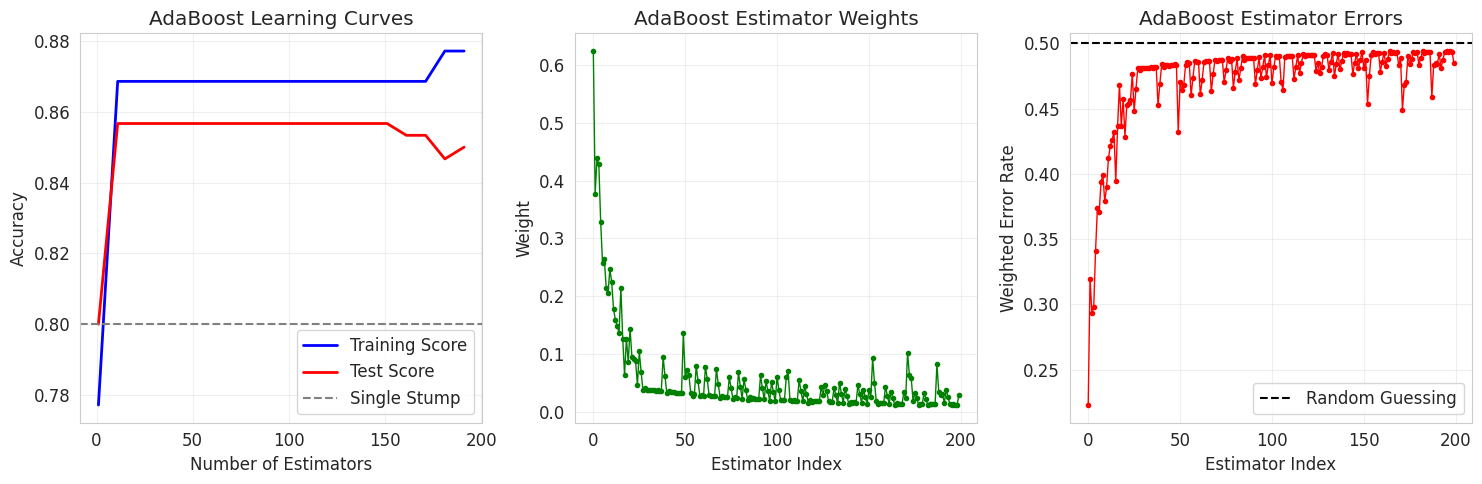

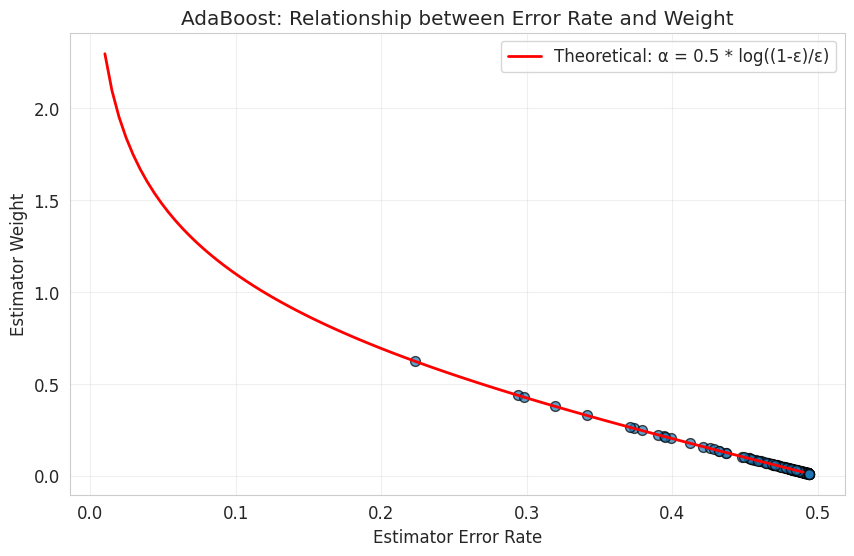


Improvement over single stump: 4.67 percentage points
Best test score achieved: 0.8567 at 11 estimators


In [37]:
# AdaBoost Implementation and Analysis
print("=== ADABOOST DEMONSTRATION ===")

# Create a more challenging dataset for AdaBoost
print("Creating challenging dataset for AdaBoost...")
X_boost, y_boost = make_moons(n_samples=1000, noise=0.4, random_state=42)
X_boost_train, X_boost_test, y_boost_train, y_boost_test = train_test_split(
    X_boost, y_boost, test_size=0.3, random_state=42
)

# Train AdaBoost with Decision Stumps
print("\nTraining AdaBoost with Decision Stumps...")
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),  # Decision stumps
    n_estimators=200,
    algorithm="SAMME.R",  # Uses probability estimates
    learning_rate=0.5,
    random_state=42
)

ada_clf.fit(X_boost_train, y_boost_train)
ada_score = ada_clf.score(X_boost_test, y_boost_test)
print(f"AdaBoost Accuracy: {ada_score:.4f}")

# Compare with single Decision Stump
stump_clf = DecisionTreeClassifier(max_depth=1, random_state=42)
stump_clf.fit(X_boost_train, y_boost_train)
stump_score = stump_clf.score(X_boost_test, y_boost_test)
print(f"Single Decision Stump Accuracy: {stump_score:.4f}")

# Analyze feature importances and estimator weights
print(f"\n=== ADABOOST ANALYSIS ===")
print(f"Number of estimators: {len(ada_clf.estimators_)}")
print(f"Estimator weights (first 10): {ada_clf.estimator_weights_[:10]}")
print(f"Estimator errors (first 10): {ada_clf.estimator_errors_[:10]}")
print(f"Feature importances: {ada_clf.feature_importances_}")

# Visualize learning progress
# Train multiple AdaBoost models with different numbers of estimators
estimator_range = range(1, 201, 10)
ada_train_scores = []
ada_test_scores = []

for n_est in estimator_range:
    ada_temp = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1),
        n_estimators=n_est,
        learning_rate=0.5,
        random_state=42
    )
    ada_temp.fit(X_boost_train, y_boost_train)

    train_score = ada_temp.score(X_boost_train, y_boost_train)
    test_score = ada_temp.score(X_boost_test, y_boost_test)

    ada_train_scores.append(train_score)
    ada_test_scores.append(test_score)

# Plot learning curves
plt.figure(figsize=(15, 5))

# Plot 1: Learning curves
plt.subplot(1, 3, 1)
plt.plot(estimator_range, ada_train_scores, 'b-', linewidth=2, label='Training Score')
plt.plot(estimator_range, ada_test_scores, 'r-', linewidth=2, label='Test Score')
plt.axhline(y=stump_score, color='gray', linestyle='--', label='Single Stump')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('AdaBoost Learning Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Estimator weights
plt.subplot(1, 3, 2)
plt.plot(ada_clf.estimator_weights_, 'go-', linewidth=1, markersize=3)
plt.xlabel('Estimator Index')
plt.ylabel('Weight')
plt.title('AdaBoost Estimator Weights')
plt.grid(True, alpha=0.3)

# Plot 3: Estimator errors
plt.subplot(1, 3, 3)
plt.plot(ada_clf.estimator_errors_, 'ro-', linewidth=1, markersize=3)
plt.axhline(y=0.5, color='black', linestyle='--', label='Random Guessing')
plt.xlabel('Estimator Index')
plt.ylabel('Weighted Error Rate')
plt.title('AdaBoost Estimator Errors')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze the relationship between weights and errors
plt.figure(figsize=(10, 6))
plt.scatter(ada_clf.estimator_errors_, ada_clf.estimator_weights_,
           alpha=0.7, s=50, edgecolors='black')
plt.xlabel('Estimator Error Rate')
plt.ylabel('Estimator Weight')
plt.title('AdaBoost: Relationship between Error Rate and Weight')
plt.grid(True, alpha=0.3)

# Add theoretical curve
error_range = np.linspace(0.01, 0.49, 100)
theoretical_weights = 0.5 * np.log((1 - error_range) / error_range)  # learning_rate = 0.5
plt.plot(error_range, theoretical_weights, 'r-', linewidth=2,
         label='Theoretical: α = 0.5 * log((1-ε)/ε)')
plt.legend()
plt.show()

print(f"\nImprovement over single stump: {(ada_score - stump_score)*100:.2f} percentage points")
print(f"Best test score achieved: {max(ada_test_scores):.4f} at {estimator_range[np.argmax(ada_test_scores)]} estimators")


=== GRADIENT BOOSTING DEMONSTRATION ===
Creating noisy quadratic dataset for regression...
Regression dataset shape: (200, 1)
Training set size: 140

Manual Gradient Boosting implementation...
Initial prediction (mean): 0.5304

Tree 1:
  Mean absolute residual: 0.4680
  MSE after tree 1: 0.0703

Tree 2:
  Mean absolute residual: 0.2100
  MSE after tree 2: 0.0406

Tree 3:
  Mean absolute residual: 0.1590
  MSE after tree 3: 0.0384

Manual Gradient Boosting Test MSE: 0.0527

Scikit-learn Gradient Boosting comparison...
Scikit-learn Gradient Boosting Test MSE: 0.0638
Single Decision Tree Test MSE: 0.0579


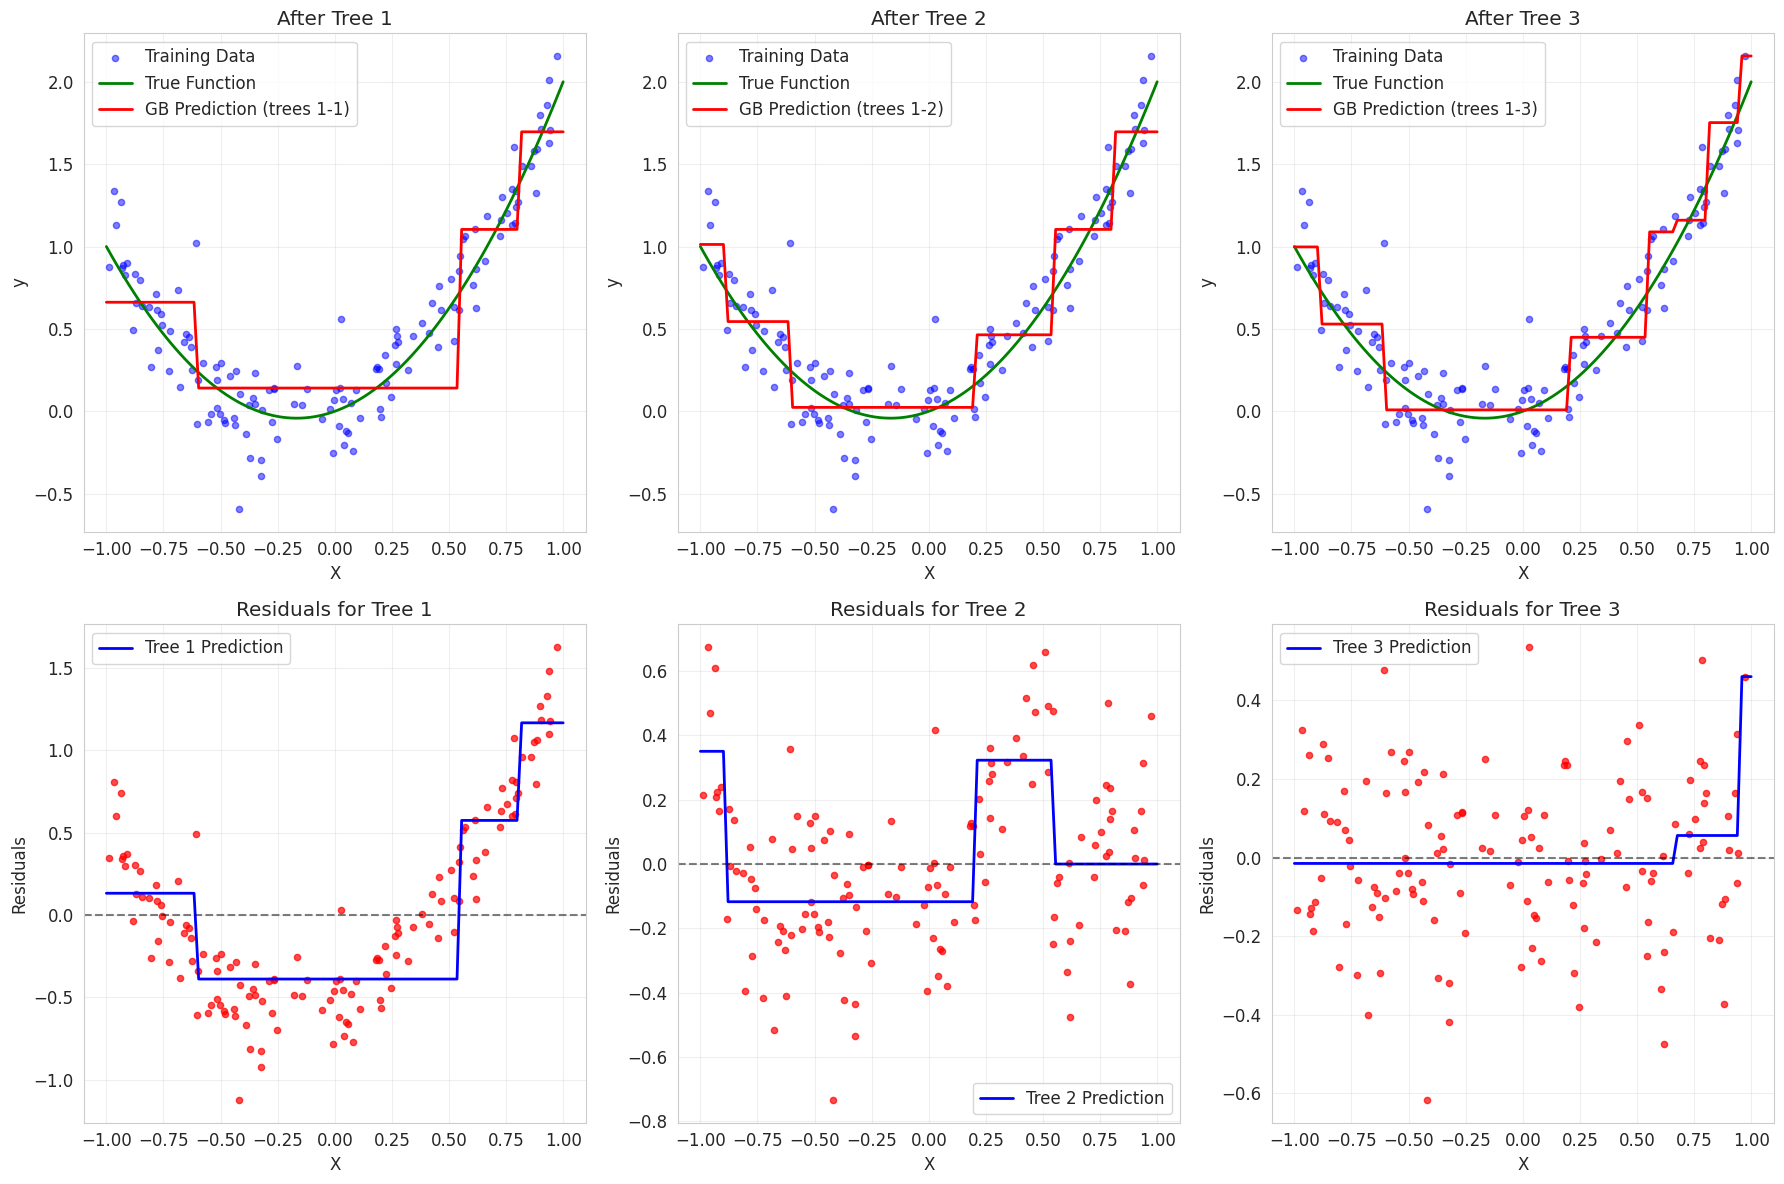


=== LEARNING RATE ANALYSIS ===
Learning rate 0.1: Train R² = 0.9253, Test R² = 0.8405
Learning rate 0.3: Train R² = 0.9623, Test R² = 0.8224
Learning rate 0.5: Train R² = 0.9795, Test R² = 0.8138
Learning rate 1.0: Train R² = 0.9937, Test R² = 0.7963
Learning rate 2.0: Train R² = 0.0000, Test R² = -0.0040


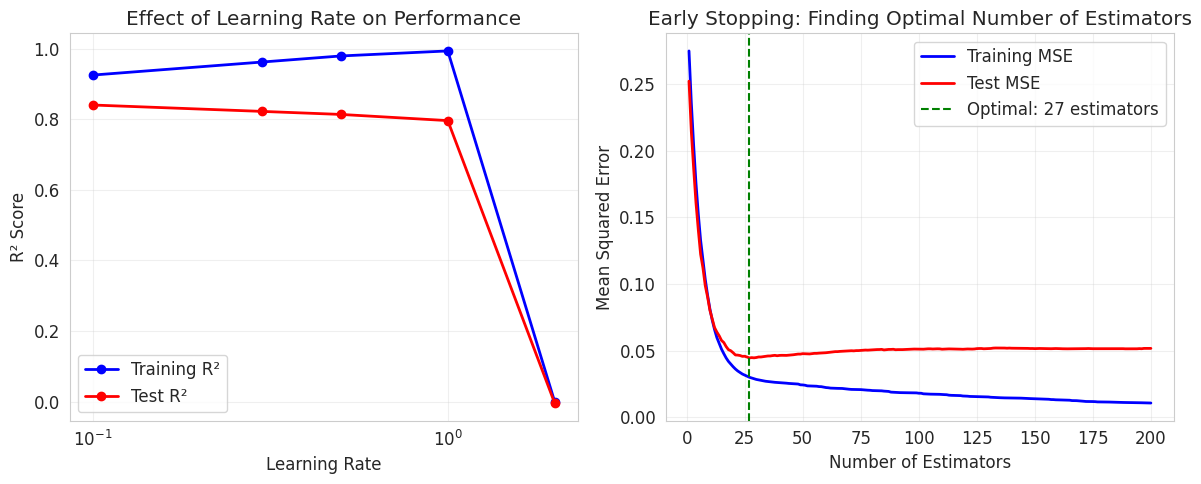


Optimal number of estimators: 27
Best test MSE: 0.0444
MSE without early stopping: 0.0516
Improvement with early stopping: 13.92%


In [38]:
# Gradient Boosting Demonstration
print("\n=== GRADIENT BOOSTING DEMONSTRATION ===")

# Create a regression dataset
print("Creating noisy quadratic dataset for regression...")
np.random.seed(42)
X_reg = np.random.uniform(-1, 1, size=(200, 1))
y_reg = 1.5 * X_reg.ravel() ** 2 + 0.5 * X_reg.ravel() + 0.2 * np.random.randn(200)

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

print(f"Regression dataset shape: {X_reg.shape}")
print(f"Training set size: {X_reg_train.shape[0]}")

# Manual implementation of Gradient Boosting for educational purposes
print("\nManual Gradient Boosting implementation...")

# Step 1: Initialize with mean
initial_prediction = np.mean(y_reg_train)
print(f"Initial prediction (mean): {initial_prediction:.4f}")

# Prepare for manual implementation
n_trees = 3
trees = []
predictions_train = np.full(len(y_reg_train), initial_prediction)

# Store residuals for visualization
all_residuals = []
all_predictions = [predictions_train.copy()]

for i in range(n_trees):
    print(f"\nTree {i+1}:")

    # Step 2: Compute residuals
    residuals = y_reg_train - predictions_train
    all_residuals.append(residuals.copy())
    print(f"  Mean absolute residual: {np.mean(np.abs(residuals)):.4f}")

    # Step 3: Train tree on residuals
    tree = DecisionTreeRegressor(max_depth=2, random_state=42)
    tree.fit(X_reg_train, residuals)
    trees.append(tree)

    # Step 4: Make predictions and update
    tree_predictions = tree.predict(X_reg_train)
    predictions_train += tree_predictions
    all_predictions.append(predictions_train.copy())

    # Calculate current MSE
    mse = mean_squared_error(y_reg_train, predictions_train)
    print(f"  MSE after tree {i+1}: {mse:.4f}")

# Make final predictions on test set
final_predictions_test = np.full(len(y_reg_test), initial_prediction)
for tree in trees:
    final_predictions_test += tree.predict(X_reg_test)

manual_mse = mean_squared_error(y_reg_test, final_predictions_test)
print(f"\nManual Gradient Boosting Test MSE: {manual_mse:.4f}")

# Compare with scikit-learn implementation
print("\nScikit-learn Gradient Boosting comparison...")
gb_reg = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=2,
    learning_rate=1.0,
    random_state=42
)

gb_reg.fit(X_reg_train, y_reg_train)
gb_predictions = gb_reg.predict(X_reg_test)
gb_mse = mean_squared_error(y_reg_test, gb_predictions)
print(f"Scikit-learn Gradient Boosting Test MSE: {gb_mse:.4f}")

# Single tree comparison
single_tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
single_tree_reg.fit(X_reg_train, y_reg_train)
single_predictions = single_tree_reg.predict(X_reg_test)
single_mse = mean_squared_error(y_reg_test, single_predictions)
print(f"Single Decision Tree Test MSE: {single_mse:.4f}")

# Visualize the gradient boosting process
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Create a range for smooth plotting
X_plot = np.linspace(-1, 1, 100).reshape(-1, 1)
y_true_plot = 1.5 * X_plot.ravel() ** 2 + 0.5 * X_plot.ravel()

# Plot the progression
for i in range(n_trees):
    # Top row: Cumulative predictions
    axes[0, i].scatter(X_reg_train, y_reg_train, alpha=0.5, color='blue', s=20, label='Training Data')
    axes[0, i].plot(X_plot, y_true_plot, 'g-', linewidth=2, label='True Function')

    # Plot cumulative prediction
    cumulative_pred = np.full(len(X_plot), initial_prediction)
    for j in range(i + 1):
        cumulative_pred += trees[j].predict(X_plot)

    axes[0, i].plot(X_plot, cumulative_pred, 'r-', linewidth=2, label=f'GB Prediction (trees 1-{i+1})')
    axes[0, i].set_title(f'After Tree {i+1}')
    axes[0, i].set_xlabel('X')
    axes[0, i].set_ylabel('y')
    axes[0, i].legend()
    axes[0, i].grid(True, alpha=0.3)

    # Bottom row: Residuals
    if i < len(all_residuals):
        axes[1, i].scatter(X_reg_train, all_residuals[i], alpha=0.7, color='red', s=20)

        # Plot tree prediction on residuals
        tree_pred_plot = trees[i].predict(X_plot)
        axes[1, i].plot(X_plot, tree_pred_plot, 'b-', linewidth=2, label=f'Tree {i+1} Prediction')

        axes[1, i].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[1, i].set_title(f'Residuals for Tree {i+1}')
        axes[1, i].set_xlabel('X')
        axes[1, i].set_ylabel('Residuals')
        axes[1, i].legend()
        axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze learning rate effect
print("\n=== LEARNING RATE ANALYSIS ===")

learning_rates = [0.1, 0.3, 0.5, 1.0, 2.0]
n_estimators_lr = 50

lr_results = []
for lr in learning_rates:
    gb_lr = GradientBoostingRegressor(
        n_estimators=n_estimators_lr,
        learning_rate=lr,
        max_depth=2,
        random_state=42
    )
    gb_lr.fit(X_reg_train, y_reg_train)

    train_score = gb_lr.score(X_reg_train, y_reg_train)
    test_score = gb_lr.score(X_reg_test, y_reg_test)

    lr_results.append((lr, train_score, test_score))
    print(f"Learning rate {lr}: Train R² = {train_score:.4f}, Test R² = {test_score:.4f}")

# Plot learning rate effects
lr_values = [result[0] for result in lr_results]
train_scores_lr = [result[1] for result in lr_results]
test_scores_lr = [result[2] for result in lr_results]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(lr_values, train_scores_lr, 'bo-', linewidth=2, label='Training R²')
plt.plot(lr_values, test_scores_lr, 'ro-', linewidth=2, label='Test R²')
plt.xlabel('Learning Rate')
plt.ylabel('R² Score')
plt.title('Effect of Learning Rate on Performance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')

# Early stopping demonstration
plt.subplot(1, 2, 2)
gb_staged = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1,
                                     max_depth=2, random_state=42)
gb_staged.fit(X_reg_train, y_reg_train)

# Get staged predictions
train_errors = [mean_squared_error(y_reg_train, pred)
                for pred in gb_staged.staged_predict(X_reg_train)]
test_errors = [mean_squared_error(y_reg_test, pred)
               for pred in gb_staged.staged_predict(X_reg_test)]

plt.plot(range(1, len(train_errors) + 1), train_errors, 'b-', linewidth=2, label='Training MSE')
plt.plot(range(1, len(test_errors) + 1), test_errors, 'r-', linewidth=2, label='Test MSE')

# Find optimal number of estimators
optimal_n_estimators = np.argmin(test_errors) + 1
plt.axvline(x=optimal_n_estimators, color='green', linestyle='--',
            label=f'Optimal: {optimal_n_estimators} estimators')

plt.xlabel('Number of Estimators')
plt.ylabel('Mean Squared Error')
plt.title('Early Stopping: Finding Optimal Number of Estimators')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOptimal number of estimators: {optimal_n_estimators}")
print(f"Best test MSE: {min(test_errors):.4f}")
print(f"MSE without early stopping: {test_errors[-1]:.4f}")
print(f"Improvement with early stopping: {((test_errors[-1] - min(test_errors))/test_errors[-1]*100):.2f}%")


=== XGBOOST DEMONSTRATION ===
Training XGBoost Regressor...
XGBoost Test MSE: 0.0519
XGBoost Test R²: 0.8263

=== GRADIENT BOOSTING METHODS COMPARISON ===
Manual GB (3 trees)      : MSE = 0.0527
Scikit-learn GB          : MSE = 0.0638
XGBoost                  : MSE = 0.0519
Single Tree              : MSE = 0.0579


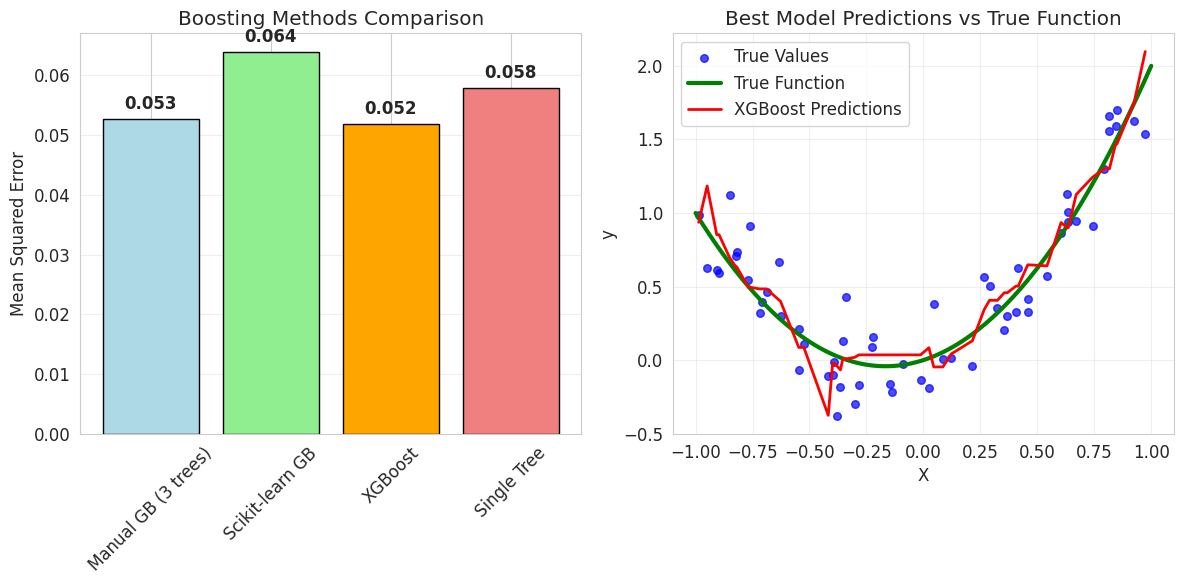

In [39]:
# XGBoost Demonstration
print("\n=== XGBOOST DEMONSTRATION ===")

# XGBoost Regressor
print("Training XGBoost Regressor...")
xgb_reg = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)

xgb_reg.fit(X_reg_train, y_reg_train)
xgb_predictions = xgb_reg.predict(X_reg_test)
xgb_mse = mean_squared_error(y_reg_test, xgb_predictions)
xgb_r2 = xgb_reg.score(X_reg_test, y_reg_test)

print(f"XGBoost Test MSE: {xgb_mse:.4f}")
print(f"XGBoost Test R²: {xgb_r2:.4f}")

# Compare all gradient boosting methods
print("\n=== GRADIENT BOOSTING METHODS COMPARISON ===")
boosting_results = {
    'Manual GB (3 trees)': manual_mse,
    'Scikit-learn GB': gb_mse,
    'XGBoost': xgb_mse,
    'Single Tree': single_mse
}

for method, mse in boosting_results.items():
    print(f"{method:<25}: MSE = {mse:.4f}")

# Visualize final comparison
plt.figure(figsize=(12, 6))

# Plot 1: MSE comparison
plt.subplot(1, 2, 1)
methods = list(boosting_results.keys())
mse_values = list(boosting_results.values())
colors = ['lightblue', 'lightgreen', 'orange', 'lightcoral']

bars = plt.bar(methods, mse_values, color=colors, edgecolor='black')
plt.ylabel('Mean Squared Error')
plt.title('Boosting Methods Comparison')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, mse in zip(bars, mse_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{mse:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Predictions vs True values
plt.subplot(1, 2, 2)
plt.scatter(X_reg_test, y_reg_test, alpha=0.7, color='blue', s=30, label='True Values')
plt.plot(X_plot, y_true_plot, 'g-', linewidth=3, label='True Function')

# Plot predictions from best model (XGBoost)
X_test_sorted = np.sort(X_reg_test.ravel())
xgb_pred_sorted = xgb_reg.predict(X_test_sorted.reshape(-1, 1))
plt.plot(X_test_sorted, xgb_pred_sorted, 'r-', linewidth=2, label='XGBoost Predictions')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Best Model Predictions vs True Function')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Stacking (Stacked Generalization)

## Theory

**Stacking** uses a meta-learner to combine predictions from multiple base learners.

### Algorithm:
1. Split training set into two parts: train_base and train_meta
2. Train base learners on train_base
3. Use base learners to predict on train_meta → create meta-features
4. Train meta-learner on meta-features with train_meta targets
5. For prediction: base learners → meta-features → meta-learner → final prediction

### Mathematical Foundation

**Level 0 (Base Learners):**
$$h_1(x), h_2(x), ..., h_N(x)$$

**Level 1 (Meta-learner):**
$$g(h_1(x), h_2(x), ..., h_N(x)) = \hat{y}$$

**Cross-Validation Stacking:**
To prevent overfitting, use k-fold CV to generate meta-features:
1. Split training data into k folds
2. For each fold: train base learners on other k-1 folds, predict on current fold
3. Combine all out-of-fold predictions as meta-features
4. Train meta-learner on these meta-features

=== STACKING IMPLEMENTATION ===
Implementing Stacking for Classification...
Base learners: ['logistic', 'random_forest', 'svm']
Meta learner: LogisticRegression

Creating meta-features using 5-fold cross-validation...
  Processing fold 1/5...
  Processing fold 2/5...
  Processing fold 3/5...
  Processing fold 4/5...
  Processing fold 5/5...
Meta-features shape: (700, 3)
Meta-features preview (first 5 samples):
[[0.03599209 0.         0.02628867]
 [0.05696673 0.         0.01979834]
 [0.35393052 0.86       0.75996092]
 [0.29551913 0.02       0.04305786]
 [0.34220373 0.95       0.84027519]]

Training meta-learner...

Creating meta-features for test set...

Stacking ensemble accuracy: 0.9167

=== STACKING vs INDIVIDUAL LEARNERS ===
logistic       : 0.8533
random_forest  : 0.9133
svm            : 0.9167
Hard Voting     : 0.9133
Soft Voting     : 0.9133
Stacking        : 0.9167


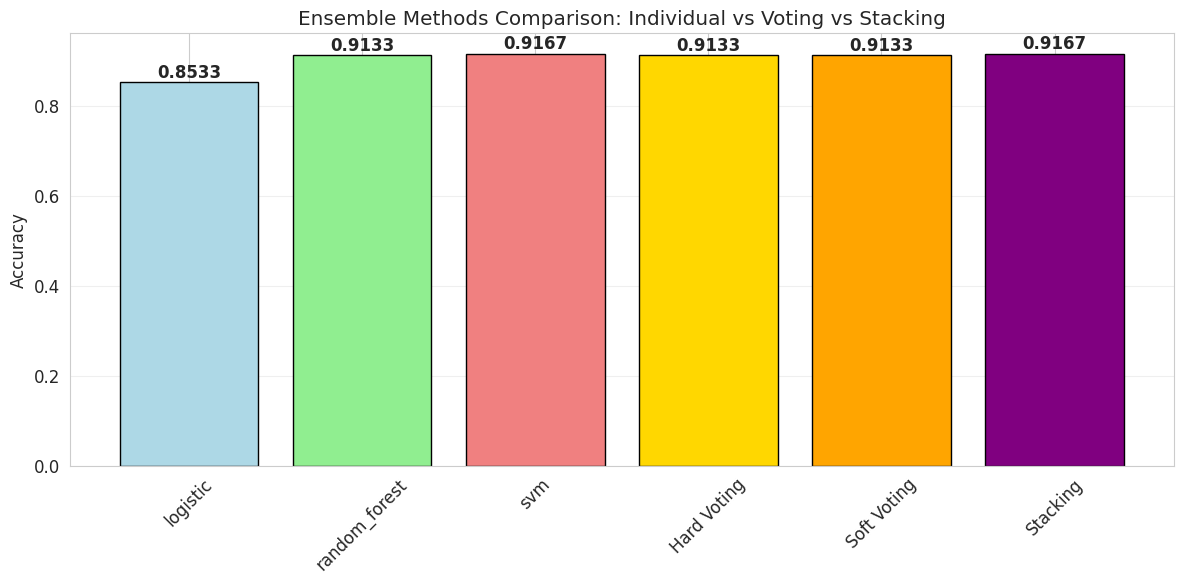


=== META-LEARNER ANALYSIS ===
Meta-learner coefficients: [0.57957396 1.59903851 4.10281957]
Meta-learner intercept: -3.0871

Meta-learner feature importance (absolute coefficients):
logistic       : 0.5796
random_forest  : 1.5990
svm            : 4.1028

Improvement Analysis:
Best individual: 0.9167
Stacking improvement: 0.00 percentage points
Stacking vs Hard Voting: 0.33 percentage points
Stacking vs Soft Voting: 0.33 percentage points


In [40]:
# Manual Stacking Implementation
print("=== STACKING IMPLEMENTATION ===")

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

# Use the moons dataset for classification stacking
print("Implementing Stacking for Classification...")

# Define base learners
base_learners = [
    ('logistic', LogisticRegression(random_state=42)),
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(probability=True, random_state=42))
]

# Define meta-learner
meta_learner = LogisticRegression(random_state=42)

print(f"Base learners: {[name for name, _ in base_learners]}")
print(f"Meta learner: {type(meta_learner).__name__}")

# Manual cross-validation stacking
def create_stacking_features(X, y, base_learners, cv_folds=5):
    """
    Create meta-features using cross-validation to prevent overfitting.

    This function implements the core of stacking:
    1. Use CV to train base learners on train folds
    2. Predict on validation fold to create 'clean' predictions
    3. Combine all out-of-fold predictions as meta-features
    """
    n_samples = X.shape[0]
    n_base_learners = len(base_learners)

    # Initialize meta-features array
    meta_features = np.zeros((n_samples, n_base_learners))

    # Create cross-validation folds
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

    print(f"\nCreating meta-features using {cv_folds}-fold cross-validation...")

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"  Processing fold {fold_idx + 1}/{cv_folds}...")

        X_fold_train, X_fold_val = X[train_idx], X[val_idx]
        y_fold_train = y[train_idx]

        # Train each base learner and predict on validation fold
        for learner_idx, (name, learner) in enumerate(base_learners):
            # Clone the learner to avoid interference
            learner_copy = learner.__class__(**learner.get_params())

            # Train on fold training data
            learner_copy.fit(X_fold_train, y_fold_train)

            # Predict probabilities on validation fold
            if hasattr(learner_copy, 'predict_proba'):
                # Use probability of positive class
                val_pred = learner_copy.predict_proba(X_fold_val)[:, 1]
            else:
                # Fallback to decision function or predictions
                val_pred = learner_copy.predict(X_fold_val)

            # Store meta-features
            meta_features[val_idx, learner_idx] = val_pred

    return meta_features

# Create meta-features
meta_X_train = create_stacking_features(X_train, y_train, base_learners)

print(f"Meta-features shape: {meta_X_train.shape}")
print(f"Meta-features preview (first 5 samples):")
print(meta_X_train[:5])

# Train meta-learner
print("\nTraining meta-learner...")
meta_learner.fit(meta_X_train, y_train)

# Create meta-features for test set
print("\nCreating meta-features for test set...")

# Train base learners on full training set
trained_base_learners = []
for name, learner in base_learners:
    learner_copy = learner.__class__(**learner.get_params())
    learner_copy.fit(X_train, y_train)
    trained_base_learners.append((name, learner_copy))

# Generate meta-features for test set
meta_X_test = np.zeros((X_test.shape[0], len(base_learners)))

for learner_idx, (name, learner) in enumerate(trained_base_learners):
    if hasattr(learner, 'predict_proba'):
        meta_X_test[:, learner_idx] = learner.predict_proba(X_test)[:, 1]
    else:
        meta_X_test[:, learner_idx] = learner.predict(X_test)

# Make final predictions
stacking_predictions = meta_learner.predict(meta_X_test)
stacking_score = accuracy_score(y_test, stacking_predictions)

print(f"\nStacking ensemble accuracy: {stacking_score:.4f}")

# Compare with individual base learners and voting
print("\n=== STACKING vs INDIVIDUAL LEARNERS ===")

# Individual base learner scores
base_scores = []
for name, learner in trained_base_learners:
    score = learner.score(X_test, y_test)
    base_scores.append(score)
    print(f"{name:<15}: {score:.4f}")

# Voting classifier comparison
voting_clf_hard = VotingClassifier(
    estimators=[(name, learner) for name, learner in base_learners],
    voting='hard'
)
voting_clf_hard.fit(X_train, y_train)
voting_hard_score = voting_clf_hard.score(X_test, y_test)

voting_clf_soft = VotingClassifier(
    estimators=[(name, learner) for name, learner in base_learners],
    voting='soft'
)
voting_clf_soft.fit(X_train, y_train)
voting_soft_score = voting_clf_soft.score(X_test, y_test)

print(f"Hard Voting     : {voting_hard_score:.4f}")
print(f"Soft Voting     : {voting_soft_score:.4f}")
print(f"Stacking        : {stacking_score:.4f}")

# Visualize results
all_methods = ([f"{name}" for name, _ in base_learners] +
               ['Hard Voting', 'Soft Voting', 'Stacking'])
all_scores = base_scores + [voting_hard_score, voting_soft_score, stacking_score]

plt.figure(figsize=(12, 6))
colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold', 'orange', 'purple']
bars = plt.bar(all_methods, all_scores, color=colors, edgecolor='black')

plt.ylabel('Accuracy')
plt.title('Ensemble Methods Comparison: Individual vs Voting vs Stacking')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, score in zip(bars, all_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Analyze meta-learner coefficients
print("\n=== META-LEARNER ANALYSIS ===")
print(f"Meta-learner coefficients: {meta_learner.coef_[0]}")
print(f"Meta-learner intercept: {meta_learner.intercept_[0]:.4f}")

print("\nMeta-learner feature importance (absolute coefficients):")
for i, (name, _) in enumerate(base_learners):
    importance = abs(meta_learner.coef_[0][i])
    print(f"{name:<15}: {importance:.4f}")

# Best improvement analysis
best_individual = max(base_scores)
print(f"\nImprovement Analysis:")
print(f"Best individual: {best_individual:.4f}")
print(f"Stacking improvement: {(stacking_score - best_individual)*100:.2f} percentage points")
print(f"Stacking vs Hard Voting: {(stacking_score - voting_hard_score)*100:.2f} percentage points")
print(f"Stacking vs Soft Voting: {(stacking_score - voting_soft_score)*100:.2f} percentage points")

# 7. Exercises and Solutions

## Exercise Solutions (Based on Appendix A)

### Theoretical Foundation for Exercises

Before solving the exercises, let's establish the key theoretical concepts:

## Exercise 1: Combining Models with 95% Precision

**Question**: If you have trained five different models and they all achieve 95% precision, you can try combining them into a voting ensemble, which will often give you even better results. It works better if the models are very different (e.g., an SVM classifier, a Decision Tree classifier, a Logistic Regression classifier, and so on). It is even better if they are trained on different training instances (that's the whole point of bagging and pasting ensembles), but if not this will still be effective as long as the models are very different.

**Mathematical Analysis**:

For models with precision $p = 0.95$, the ensemble precision depends on error correlation.

**Independent Errors Case**:
If errors are independent, majority voting probability:
$$P(\text{majority correct}) = \sum_{k=3}^{5} \binom{5}{k} p^k (1-p)^{5-k}$$

**Correlated Errors Case**:
If models make similar errors, improvement is limited.

**Solution**: Yes, combining them can improve results if:
1. Models are diverse (different algorithms)
2. Errors are not perfectly correlated
3. Individual models are better than random guessing

The improvement comes from error diversity - when one model fails, others might succeed.

=== EXERCISE 1: COMBINING HIGH-PRECISION MODELS ===
Correlation 0.0: Individual=0.9546, Ensemble=0.9996, Improvement=+0.0450
Correlation 0.3: Individual=0.9537, Ensemble=0.9898, Improvement=+0.0361
Correlation 0.6: Individual=0.9517, Ensemble=0.9637, Improvement=+0.0120
Correlation 0.9: Individual=0.9539, Ensemble=0.9536, Improvement=-0.0003

Theoretical ensemble precision (independent models): 0.9988
Theoretical improvement: +0.0488


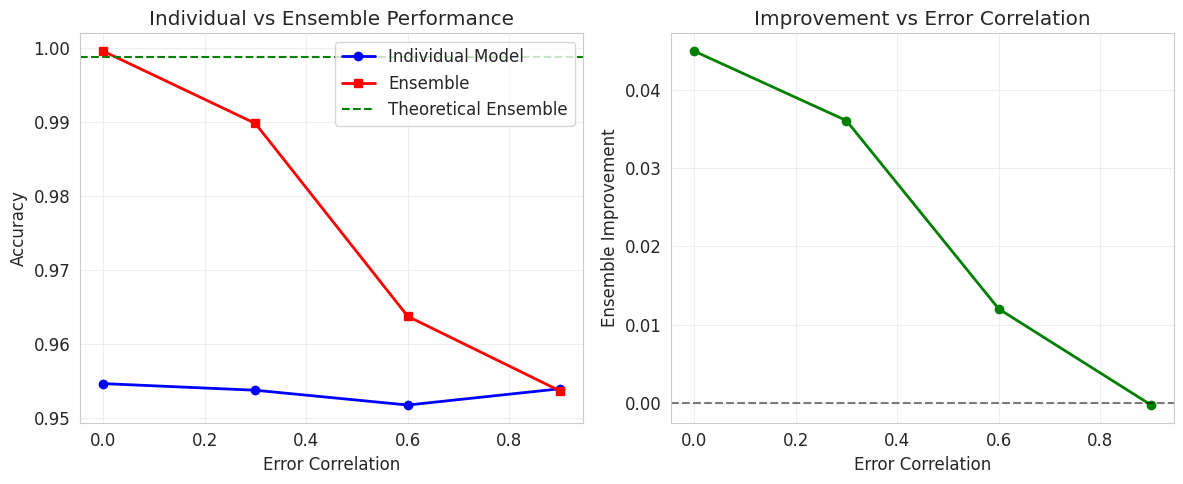


Key Insight: Ensemble improvement decreases as error correlation increases.
Diverse models (low correlation) provide the best ensemble performance.


In [41]:
# Exercise 1 Demonstration
print("=== EXERCISE 1: COMBINING HIGH-PRECISION MODELS ===")

# Simulate 5 models with 95% individual precision
def simulate_ensemble_improvement(n_models=5, individual_precision=0.95, n_samples=10000):
    """
    Simulate the effect of combining multiple high-precision models.

    We'll test different correlation levels between model errors to show
    how diversity affects ensemble performance.
    """

    results = {}

    # Test different correlation levels
    correlation_levels = [0.0, 0.3, 0.6, 0.9]  # 0 = independent, 1 = identical

    for correlation in correlation_levels:
        ensemble_correct = 0
        individual_correct = 0

        for _ in range(n_samples):
            # Generate correlated predictions
            # Base prediction (affects all models due to correlation)
            base_correct = np.random.random() < individual_precision

            model_predictions = []
            for _ in range(n_models):
                if np.random.random() < correlation:
                    # Correlated with base prediction
                    prediction = base_correct
                else:
                    # Independent prediction
                    prediction = np.random.random() < individual_precision

                model_predictions.append(prediction)

            # Majority vote
            ensemble_prediction = sum(model_predictions) > n_models // 2

            # True answer (assume ground truth is correct when majority agrees)
            # For simulation, we'll assume the true answer
            true_answer = True  # Doesn't matter for relative comparison

            individual_correct += model_predictions[0]  # First model performance
            ensemble_correct += ensemble_prediction

        individual_acc = individual_correct / n_samples
        ensemble_acc = ensemble_correct / n_samples

        results[correlation] = {
            'individual': individual_acc,
            'ensemble': ensemble_acc,
            'improvement': ensemble_acc - individual_acc
        }

        print(f"Correlation {correlation:.1f}: Individual={individual_acc:.4f}, "
              f"Ensemble={ensemble_acc:.4f}, Improvement={ensemble_acc-individual_acc:+.4f}")

    return results

# Run simulation
simulation_results = simulate_ensemble_improvement()

# Theoretical calculation for independent case
from scipy.stats import binom

def theoretical_ensemble_precision(n_models, individual_precision):
    """Calculate theoretical ensemble precision for independent models."""
    majority_threshold = n_models // 2 + 1
    ensemble_precision = 1 - binom.cdf(majority_threshold - 1, n_models, individual_precision)
    return ensemble_precision

theoretical_precision = theoretical_ensemble_precision(5, 0.95)
print(f"\nTheoretical ensemble precision (independent models): {theoretical_precision:.4f}")
print(f"Theoretical improvement: {theoretical_precision - 0.95:+.4f}")

# Visualize results
correlations = list(simulation_results.keys())
individual_accs = [simulation_results[c]['individual'] for c in correlations]
ensemble_accs = [simulation_results[c]['ensemble'] for c in correlations]
improvements = [simulation_results[c]['improvement'] for c in correlations]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(correlations, individual_accs, 'b-', marker='o', linewidth=2, label='Individual Model')
plt.plot(correlations, ensemble_accs, 'r-', marker='s', linewidth=2, label='Ensemble')
plt.axhline(y=theoretical_precision, color='green', linestyle='--',
            label=f'Theoretical Ensemble')
plt.xlabel('Error Correlation')
plt.ylabel('Accuracy')
plt.title('Individual vs Ensemble Performance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(correlations, improvements, 'g-', marker='o', linewidth=2)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('Error Correlation')
plt.ylabel('Ensemble Improvement')
plt.title('Improvement vs Error Correlation')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insight: Ensemble improvement decreases as error correlation increases.")
print("Diverse models (low correlation) provide the best ensemble performance.")

## Exercise 2: Hard vs Soft Voting

**Question**: What is the difference between hard and soft voting classifiers?

**Mathematical Foundation**:

**Hard Voting**:
$$\hat{y} = \text{mode}\{h_1(x), h_2(x), ..., h_N(x)\}$$
- Counts discrete class predictions
- Each classifier contributes equally
- Simple majority rule

**Soft Voting**:
$$\hat{y} = \arg\max_c \left(\frac{1}{N} \sum_{i=1}^{N} P_i(y=c|x)\right)$$
- Uses class probability estimates
- Weights confident predictions more heavily
- Generally performs better when probabilities are well-calibrated

**Key Differences**:
1. **Information**: Soft voting uses more information (probabilities vs binary decisions)
2. **Confidence**: Soft voting gives more weight to confident predictions
3. **Requirements**: Soft voting requires classifiers that can estimate probabilities

=== EXERCISE 2: HARD vs SOFT VOTING DEMONSTRATION ===
Dataset shape: (1000, 20)
Classes: [0 1]

Using classifiers: ['lr', 'rf', 'svm', 'knn']

Training individual classifiers...
lr             : Accuracy=0.8567, Avg Confidence=0.8347
rf             : Accuracy=0.9133, Avg Confidence=0.8181
svm            : Accuracy=0.9400, Avg Confidence=0.9337
knn            : Accuracy=0.9500, Avg Confidence=0.8993

Implementing voting manually...

Manual Hard Voting Accuracy: 0.9400
Manual Soft Voting Accuracy: 0.9333

Scikit-learn Hard Voting: 0.9400
Scikit-learn Soft Voting: 0.9333

=== DETAILED ANALYSIS: WHEN SOFT VOTING HELPS ===
Number of instances where hard and soft voting differ: 6

Examples where predictions differ:

Sample 63:
  True label: 0
  Individual predictions: [0 0 1 1]
  Individual probabilities:
    lr: Class 0 (prob=0.421, conf=0.579)
    rf: Class 0 (prob=0.460, conf=0.540)
    svm: Class 1 (prob=0.773, conf=0.773)
    knn: Class 1 (prob=0.600, conf=0.600)
  Hard voting: 0
  Soft

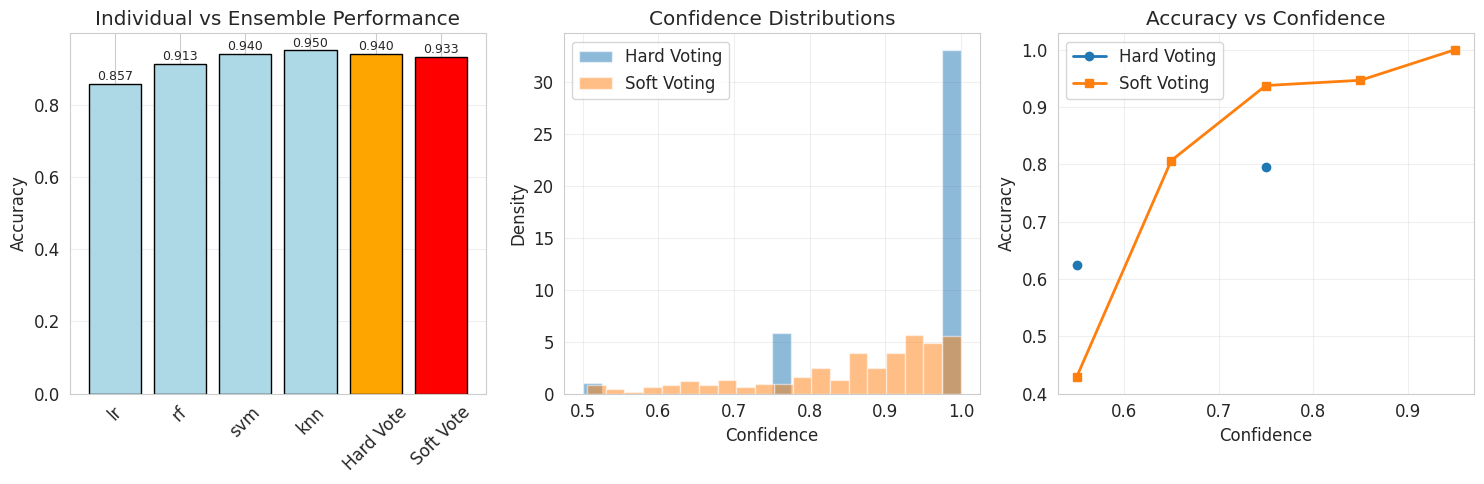


=== SUMMARY ===
Best individual classifier: 0.9500
Hard voting improvement: -0.0100
Soft voting improvement: -0.0167
Soft vs Hard voting improvement: -0.0067

Soft voting generally performs better because it uses probability information,
giving more weight to confident predictions.


In [42]:
# Exercise 2 Demonstration
print("=== EXERCISE 2: HARD vs SOFT VOTING DEMONSTRATION ===")

# Create a challenging dataset where confidence matters
from sklearn.datasets import make_classification

X_vote, y_vote = make_classification(
    n_samples=1000, n_features=20, n_informative=10, n_redundant=10,
    n_clusters_per_class=2, random_state=42
)
X_vote_train, X_vote_test, y_vote_train, y_vote_test = train_test_split(
    X_vote, y_vote, test_size=0.3, random_state=42
)

print(f"Dataset shape: {X_vote.shape}")
print(f"Classes: {np.unique(y_vote)}")

# Create diverse classifiers with different confidence patterns
classifiers = [
    ('lr', LogisticRegression(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(probability=True, random_state=42, gamma='scale')),
    ('knn', KNeighborsClassifier(n_neighbors=5))
]

print(f"\nUsing classifiers: {[name for name, _ in classifiers]}")

# Train individual classifiers and analyze their confidence
individual_scores = []
all_probabilities = []
all_predictions = []

print("\nTraining individual classifiers...")
for name, clf in classifiers:
    clf.fit(X_vote_train, y_vote_train)
    score = clf.score(X_vote_test, y_vote_test)
    individual_scores.append(score)

    # Get probabilities and predictions
    if hasattr(clf, 'predict_proba'):
        probs = clf.predict_proba(X_vote_test)
    else:
        # For classifiers without predict_proba, create fake probabilities
        preds = clf.predict(X_vote_test)
        probs = np.zeros((len(preds), 2))
        probs[preds == 0, 0] = 0.9
        probs[preds == 0, 1] = 0.1
        probs[preds == 1, 0] = 0.1
        probs[preds == 1, 1] = 0.9

    all_probabilities.append(probs)
    all_predictions.append(clf.predict(X_vote_test))

    # Analyze confidence
    confidence = np.max(probs, axis=1)
    avg_confidence = np.mean(confidence)

    print(f"{name:<15}: Accuracy={score:.4f}, Avg Confidence={avg_confidence:.4f}")

# Manual hard voting
print("\nImplementing voting manually...")

# Hard voting: majority of discrete predictions
stacked_predictions = np.column_stack(all_predictions)
hard_vote_predictions = []

for i in range(len(y_vote_test)):
    votes = stacked_predictions[i]
    # Count votes for each class
    vote_counts = np.bincount(votes)
    # Predict class with most votes
    hard_vote_predictions.append(np.argmax(vote_counts))

hard_vote_predictions = np.array(hard_vote_predictions)
hard_vote_score = accuracy_score(y_vote_test, hard_vote_predictions)

# Soft voting: average of probabilities
stacked_probabilities = np.mean(all_probabilities, axis=0)
soft_vote_predictions = np.argmax(stacked_probabilities, axis=1)
soft_vote_score = accuracy_score(y_vote_test, soft_vote_predictions)

print(f"\nManual Hard Voting Accuracy: {hard_vote_score:.4f}")
print(f"Manual Soft Voting Accuracy: {soft_vote_score:.4f}")

# Compare with scikit-learn implementations
voting_hard = VotingClassifier(estimators=classifiers, voting='hard')
voting_soft = VotingClassifier(estimators=classifiers, voting='soft')

voting_hard.fit(X_vote_train, y_vote_train)
voting_soft.fit(X_vote_train, y_vote_train)

sklearn_hard_score = voting_hard.score(X_vote_test, y_vote_test)
sklearn_soft_score = voting_soft.score(X_vote_test, y_vote_test)

print(f"\nScikit-learn Hard Voting: {sklearn_hard_score:.4f}")
print(f"Scikit-learn Soft Voting: {sklearn_soft_score:.4f}")

# Analyze specific examples where hard and soft voting differ
print("\n=== DETAILED ANALYSIS: WHEN SOFT VOTING HELPS ===")

differences = hard_vote_predictions != soft_vote_predictions
n_differences = np.sum(differences)

print(f"Number of instances where hard and soft voting differ: {n_differences}")

if n_differences > 0:
    print("\nExamples where predictions differ:")
    diff_indices = np.where(differences)[0][:5]  # Show first 5 differences

    for idx in diff_indices:
        print(f"\nSample {idx}:")
        print(f"  True label: {y_vote_test[idx]}")
        print(f"  Individual predictions: {stacked_predictions[idx]}")
        print(f"  Individual probabilities:")
        for j, (name, _) in enumerate(classifiers):
            prob_0, prob_1 = all_probabilities[j][idx]
            confidence = max(prob_0, prob_1)
            pred_class = 1 if prob_1 > prob_0 else 0
            print(f"    {name}: Class {pred_class} (prob={prob_1:.3f}, conf={confidence:.3f})")

        avg_prob_0 = np.mean([probs[idx, 0] for probs in all_probabilities])
        avg_prob_1 = np.mean([probs[idx, 1] for probs in all_probabilities])

        print(f"  Hard voting: {hard_vote_predictions[idx]}")
        print(f"  Soft voting: {soft_vote_predictions[idx]} (avg probs: [{avg_prob_0:.3f}, {avg_prob_1:.3f}])")
        print(f"  Correct prediction - Hard: {hard_vote_predictions[idx] == y_vote_test[idx]}, "
              f"Soft: {soft_vote_predictions[idx] == y_vote_test[idx]}")

# Visualize confidence distributions
plt.figure(figsize=(15, 5))

# Plot 1: Individual classifier accuracies
plt.subplot(1, 3, 1)
classifier_names = [name for name, _ in classifiers]
all_scores = individual_scores + [hard_vote_score, soft_vote_score]
all_names = classifier_names + ['Hard Vote', 'Soft Vote']
colors = ['lightblue'] * len(classifiers) + ['orange', 'red']

bars = plt.bar(all_names, all_scores, color=colors, edgecolor='black')
plt.ylabel('Accuracy')
plt.title('Individual vs Ensemble Performance')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, score in zip(bars, all_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
             f'{score:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Confidence distribution comparison
plt.subplot(1, 3, 2)
hard_confidences = []
soft_confidences = np.max(stacked_probabilities, axis=1)

# For hard voting, confidence is the proportion of agreeing classifiers
for i in range(len(y_vote_test)):
    votes = stacked_predictions[i]
    most_common_count = np.max(np.bincount(votes))
    confidence = most_common_count / len(classifiers)
    hard_confidences.append(confidence)

plt.hist(hard_confidences, bins=20, alpha=0.5, label='Hard Voting', density=True)
plt.hist(soft_confidences, bins=20, alpha=0.5, label='Soft Voting', density=True)
plt.xlabel('Confidence')
plt.ylabel('Density')
plt.title('Confidence Distributions')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Accuracy vs Confidence
plt.subplot(1, 3, 3)
# Bin by confidence and calculate accuracy in each bin
confidence_bins = np.linspace(0.5, 1.0, 6)
hard_acc_by_conf = []
soft_acc_by_conf = []
bin_centers = []

for i in range(len(confidence_bins) - 1):
    low, high = confidence_bins[i], confidence_bins[i + 1]
    bin_centers.append((low + high) / 2)

    # Hard voting
    mask_hard = (np.array(hard_confidences) >= low) & (np.array(hard_confidences) < high)
    if np.sum(mask_hard) > 0:
        acc_hard = np.mean(hard_vote_predictions[mask_hard] == y_vote_test[mask_hard])
        hard_acc_by_conf.append(acc_hard)
    else:
        hard_acc_by_conf.append(np.nan)

    # Soft voting
    mask_soft = (soft_confidences >= low) & (soft_confidences < high)
    if np.sum(mask_soft) > 0:
        acc_soft = np.mean(soft_vote_predictions[mask_soft] == y_vote_test[mask_soft])
        soft_acc_by_conf.append(acc_soft)
    else:
        soft_acc_by_conf.append(np.nan)

plt.plot(bin_centers, hard_acc_by_conf, 'o-', linewidth=2, label='Hard Voting')
plt.plot(bin_centers, soft_acc_by_conf, 's-', linewidth=2, label='Soft Voting')
plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Confidence')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== SUMMARY ===")
print(f"Best individual classifier: {max(individual_scores):.4f}")
print(f"Hard voting improvement: {hard_vote_score - max(individual_scores):+.4f}")
print(f"Soft voting improvement: {soft_vote_score - max(individual_scores):+.4f}")
print(f"Soft vs Hard voting improvement: {soft_vote_score - hard_vote_score:+.4f}")
print(f"\nSoft voting generally performs better because it uses probability information,")
print(f"giving more weight to confident predictions.")

## Exercise 3: Parallelization of Ensemble Methods

**Question**: Is it possible to speed up training of a bagging ensemble by distributing it across multiple servers? What about pasting ensembles, boosting ensembles, Random Forests, or stacking ensembles?

**Theoretical Analysis**:

**Parallelizable Methods** (Independent Training):
- **Bagging**: ✅ Each predictor trains on independent bootstrap sample
- **Pasting**: ✅ Each predictor trains on independent subset
- **Random Forests**: ✅ Same as bagging + random feature selection
- **Stacking (within layer)**: ✅ Predictors in same layer are independent

**Sequential Methods** (Dependent Training):
- **Boosting**: ❌ Each predictor depends on previous predictor's errors
- **Stacking (between layers)**: ❌ Next layer depends on previous layer's outputs

**Mathematical Foundation**:

**Parallel Efficiency**: For $p$ processors and $n$ predictors:
$$\text{Speedup} = \frac{T_{sequential}}{T_{parallel}} \leq \min(p, n)$$

**Communication Overhead**: Real speedup is reduced by:
$$T_{actual} = T_{computation}/p + T_{communication}$$

=== EXERCISE 3: PARALLELIZATION ANALYSIS ===
Dataset shape: (5000, 50)
Available CPU cores: 2

Testing parallel training with 100 estimators...

=== BAGGING PARALLELIZATION ===

Testing Bagging with n_jobs=1...
  Training time: 36.38 seconds

Testing Bagging with n_jobs=2...
  Training time: 27.31 seconds
  Speedup vs sequential: 1.33x

Testing Bagging with n_jobs=4...
  Training time: 28.96 seconds
  Speedup vs sequential: 1.26x

Testing Bagging with n_jobs=-1...
  Training time: 27.10 seconds
  Speedup vs sequential: 1.34x

=== RANDOM FOREST PARALLELIZATION ===

Testing Random Forest with n_jobs=1...
  Training time: 5.00 seconds

Testing Random Forest with n_jobs=2...
  Training time: 4.94 seconds
  Speedup vs sequential: 1.01x

Testing Random Forest with n_jobs=4...
  Training time: 3.33 seconds
  Speedup vs sequential: 1.50x

Testing Random Forest with n_jobs=-1...
  Training time: 4.71 seconds
  Speedup vs sequential: 1.06x

=== ADABOOST (SEQUENTIAL) ===
Testing AdaBoost (inheren

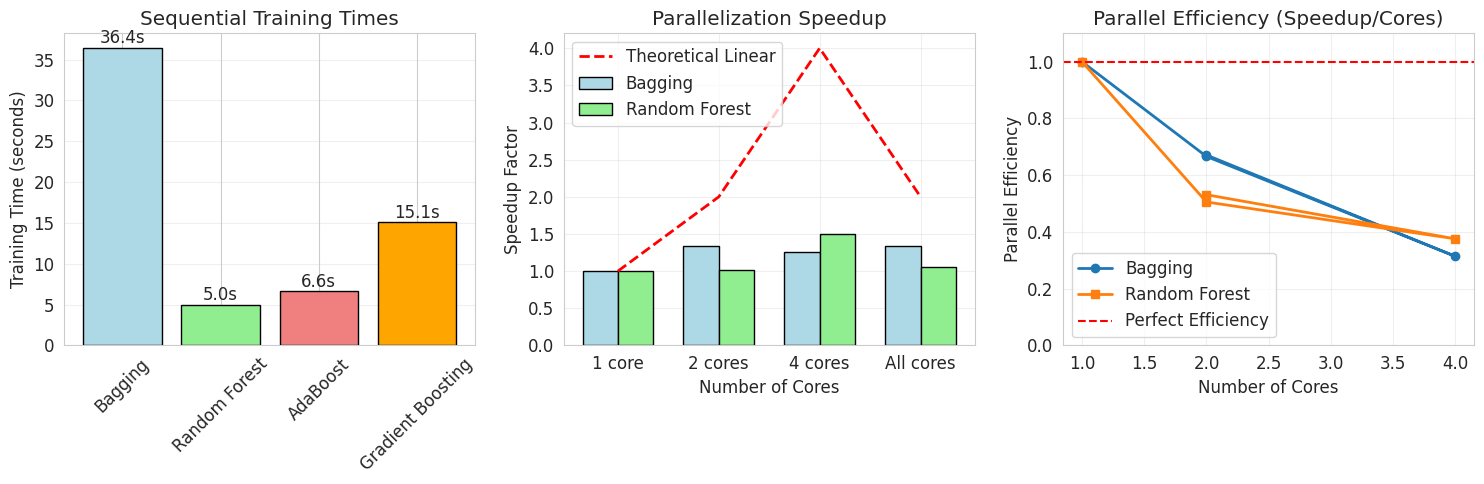


=== PARALLELIZATION SUMMARY ===
✅ EASILY PARALLELIZABLE:
   • Bagging: 1.34x speedup with all cores
   • Random Forests: 1.06x speedup with all cores
   • Pasting: Similar to bagging
   • Stacking (within layers): Each layer can be parallelized

❌ NOT PARALLELIZABLE:
   • AdaBoost: Sequential weight updates required
   • Gradient Boosting: Sequential residual fitting required
   • Stacking (between layers): Layer N depends on Layer N-1

💡 KEY INSIGHT: Parallelization works when predictors are independent!


In [43]:
# Exercise 3 Demonstration: Parallelization Analysis
print("=== EXERCISE 3: PARALLELIZATION ANALYSIS ===")

import time
from joblib import Parallel, delayed
import multiprocessing

# Create a larger dataset for timing analysis
X_parallel, y_parallel = make_classification(
    n_samples=5000, n_features=50, n_informative=25,
    n_clusters_per_class=3, random_state=42
)

print(f"Dataset shape: {X_parallel.shape}")
print(f"Available CPU cores: {multiprocessing.cpu_count()}")

# Test different numbers of jobs for parallel methods
n_jobs_options = [1, 2, 4, -1]  # -1 means all available cores
n_estimators = 100

print(f"\nTesting parallel training with {n_estimators} estimators...")

# 1. BAGGING - Should parallelize well
print("\n=== BAGGING PARALLELIZATION ===")
bagging_times = []

for n_jobs in n_jobs_options:
    print(f"\nTesting Bagging with n_jobs={n_jobs}...")

    start_time = time.time()
    bag_clf = BaggingClassifier(
        DecisionTreeClassifier(),
        n_estimators=n_estimators,
        n_jobs=n_jobs,
        random_state=42
    )
    bag_clf.fit(X_parallel, y_parallel)
    training_time = time.time() - start_time

    bagging_times.append(training_time)
    print(f"  Training time: {training_time:.2f} seconds")

    if len(bagging_times) > 1:
        speedup = bagging_times[0] / training_time
        print(f"  Speedup vs sequential: {speedup:.2f}x")

# 2. RANDOM FOREST - Should parallelize well
print("\n=== RANDOM FOREST PARALLELIZATION ===")
rf_times = []

for n_jobs in n_jobs_options:
    print(f"\nTesting Random Forest with n_jobs={n_jobs}...")

    start_time = time.time()
    rf_clf = RandomForestClassifier(
        n_estimators=n_estimators,
        n_jobs=n_jobs,
        random_state=42
    )
    rf_clf.fit(X_parallel, y_parallel)
    training_time = time.time() - start_time

    rf_times.append(training_time)
    print(f"  Training time: {training_time:.2f} seconds")

    if len(rf_times) > 1:
        speedup = rf_times[0] / training_time
        print(f"  Speedup vs sequential: {speedup:.2f}x")

# 3. ADABOOST - Cannot parallelize (sequential by nature)
print("\n=== ADABOOST (SEQUENTIAL) ===")
print("Testing AdaBoost (inherently sequential)...")

start_time = time.time()
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=n_estimators,
    random_state=42
)
ada_clf.fit(X_parallel, y_parallel)
ada_time = time.time() - start_time

print(f"  Training time: {ada_time:.2f} seconds")
print(f"  Note: AdaBoost cannot be parallelized due to sequential dependency")

# 4. GRADIENT BOOSTING - Cannot parallelize training
print("\n=== GRADIENT BOOSTING (SEQUENTIAL) ===")
print("Testing Gradient Boosting (inherently sequential)...")

start_time = time.time()
gb_clf = GradientBoostingClassifier(
    n_estimators=n_estimators,
    random_state=42
)
gb_clf.fit(X_parallel, y_parallel)
gb_time = time.time() - start_time

print(f"  Training time: {gb_time:.2f} seconds")
print(f"  Note: Gradient Boosting cannot be parallelized due to sequential dependency")

# Demonstrate why boosting is sequential
print("\n=== WHY BOOSTING IS SEQUENTIAL ===")
print("Simulating AdaBoost sequential dependency...")

# Create simple dataset
X_simple = np.array([[1], [2], [3], [4]])
y_simple = np.array([0, 0, 1, 1])

# Initial weights
weights = np.ones(len(X_simple)) / len(X_simple)
print(f"Initial weights: {weights}")

# Train first classifier
clf1 = DecisionTreeClassifier(max_depth=1, random_state=42)
clf1.fit(X_simple, y_simple, sample_weight=weights)
pred1 = clf1.predict(X_simple)
error1 = np.sum(weights[pred1 != y_simple]) / np.sum(weights)

print(f"Classifier 1 predictions: {pred1}")
print(f"Classifier 1 error: {error1:.3f}")

# Update weights (simplified)
alpha1 = 0.5 * np.log((1 - error1) / error1)
weights[pred1 != y_simple] *= np.exp(alpha1)
weights /= np.sum(weights)  # Normalize

print(f"Updated weights: {weights}")
print(f"Classifier 1 weight: {alpha1:.3f}")
print("\nNote: Second classifier MUST wait for updated weights from first classifier")
print("This dependency makes parallelization impossible in boosting methods.")

# Visualize parallelization results
plt.figure(figsize=(15, 5))

# Plot 1: Training times comparison
plt.subplot(1, 3, 1)
methods = ['Bagging', 'Random Forest', 'AdaBoost', 'Gradient Boosting']
sequential_times = [bagging_times[0], rf_times[0], ada_time, gb_time]
colors = ['lightblue', 'lightgreen', 'lightcoral', 'orange']

bars = plt.bar(methods, sequential_times, color=colors, edgecolor='black')
plt.ylabel('Training Time (seconds)')
plt.title('Sequential Training Times')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, time_val in zip(bars, sequential_times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{time_val:.1f}s', ha='center', va='bottom')

# Plot 2: Speedup analysis for parallelizable methods
plt.subplot(1, 3, 2)
n_jobs_labels = ['1 core', '2 cores', '4 cores', 'All cores']
bagging_speedups = [bagging_times[0] / t for t in bagging_times]
rf_speedups = [rf_times[0] / t for t in rf_times]

x = range(len(n_jobs_labels))
width = 0.35

plt.bar([i - width/2 for i in x], bagging_speedups, width,
        label='Bagging', color='lightblue', edgecolor='black')
plt.bar([i + width/2 for i in x], rf_speedups, width,
        label='Random Forest', color='lightgreen', edgecolor='black')

# Theoretical linear speedup
theoretical_speedup = [1, 2, 4, multiprocessing.cpu_count()]
plt.plot(x, theoretical_speedup, 'r--', linewidth=2, label='Theoretical Linear')

plt.xlabel('Number of Cores')
plt.ylabel('Speedup Factor')
plt.title('Parallelization Speedup')
plt.xticks(x, n_jobs_labels)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Efficiency analysis
plt.subplot(1, 3, 3)
cores = [1, 2, 4, multiprocessing.cpu_count()]
bagging_efficiency = [speedup / core for speedup, core in zip(bagging_speedups, cores)]
rf_efficiency = [speedup / core for speedup, core in zip(rf_speedups, cores)]

plt.plot(cores, bagging_efficiency, 'o-', linewidth=2, label='Bagging', markersize=6)
plt.plot(cores, rf_efficiency, 's-', linewidth=2, label='Random Forest', markersize=6)
plt.axhline(y=1.0, color='red', linestyle='--', label='Perfect Efficiency')

plt.xlabel('Number of Cores')
plt.ylabel('Parallel Efficiency')
plt.title('Parallel Efficiency (Speedup/Cores)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

# Summary
print(f"\n=== PARALLELIZATION SUMMARY ===")
print(f"✅ EASILY PARALLELIZABLE:")
print(f"   • Bagging: {bagging_speedups[-1]:.2f}x speedup with all cores")
print(f"   • Random Forests: {rf_speedups[-1]:.2f}x speedup with all cores")
print(f"   • Pasting: Similar to bagging")
print(f"   • Stacking (within layers): Each layer can be parallelized")
print(f"\n❌ NOT PARALLELIZABLE:")
print(f"   • AdaBoost: Sequential weight updates required")
print(f"   • Gradient Boosting: Sequential residual fitting required")
print(f"   • Stacking (between layers): Layer N depends on Layer N-1")
print(f"\n💡 KEY INSIGHT: Parallelization works when predictors are independent!")

## Exercise 4: Out-of-Bag Evaluation

**Question**: What is the benefit of out-of-bag evaluation?

**Mathematical Foundation**:

**Bootstrap Sampling**: For dataset of size $m$, each bootstrap sample leaves out:
$$P(\text{instance not selected}) = \left(1 - \frac{1}{m}\right)^m \approx e^{-1} \approx 0.368$$

**OOB Evaluation**:
- Each predictor evaluated on ~36.8% of data it never saw
- Provides unbiased performance estimate
- No need for separate validation set

**Benefits**:
1. **More training data**: No need to hold out validation set
2. **Unbiased estimates**: OOB instances never seen during training
3. **Free validation**: Computed during training with no extra cost
4. **Model selection**: Can optimize hyperparameters using OOB score

## Exercise 5: Extra-Trees vs Random Forests

**Question**: What makes Extra-Trees more random than regular Random Forests? How can this extra randomness help? Are Extra-Trees slower or faster than regular Random Forests?

**Mathematical Analysis**:

**Random Forests**:
- Random feature subset at each split
- Optimal threshold search: $\theta^* = \arg\min_\theta \text{Impurity}(\theta)$

**Extra-Trees**:
- Random feature subset at each split
- Random threshold: $\theta \sim \text{Uniform}(\min(f), \max(f))$

**Bias-Variance Trade-off**:
- Extra-Trees: Higher bias, lower variance
- Random Forests: Lower bias, higher variance

**Speed**: Extra-Trees are faster because no threshold optimization is needed.

## Exercise 6 & 7: AdaBoost and Gradient Boosting Hyperparameters

**Exercise 6**: If your AdaBoost ensemble underfits the training data, which hyperparameters should you tweak and how?

**Solution**:
- **Increase** `n_estimators`: More weak learners to improve fit
- **Increase** `learning_rate`: Stronger weight updates
- **Reduce regularization** of base estimator: Allow more complex weak learners

**Exercise 7**: If your Gradient Boosting ensemble overfits the training set, should you increase or decrease the learning rate?

**Solution**:
- **Decrease** `learning_rate`: Smaller steps prevent overfitting
- Use **early stopping**: Find optimal number of estimators
- **Increase regularization**: max_depth, min_samples_split, etc.

**Mathematical Foundation**:

**Learning Rate Effect**:
$$F_m(x) = F_{m-1}(x) + \eta \cdot h_m(x)$$

Where $\eta$ is learning rate:
- Small $\eta$: Slower learning, better generalization
- Large $\eta$: Faster learning, risk of overfitting

## Exercise 8 & 9: MNIST Ensemble Implementation

**Exercise 8**: Load the MNIST data, and split it into training, validation, and test sets. Train various classifiers and combine them into an ensemble using voting.

**Exercise 9**: Create a stacking ensemble using the predictions from Exercise 8.

**Implementation**: Based on the handson-ml2 repository solutions.

=== EXERCISES 8 & 9: MNIST ENSEMBLE IMPLEMENTATION ===
Loading MNIST dataset (subset for demo)...
MNIST subset shape: (5000, 784)
Classes: [0 1 2 3 4 5 6 7 8 9]

Splitting data: 60% train, 20% validation, 20% test...
Training set: 3000 samples
Validation set: 1000 samples
Test set: 1000 samples

=== EXERCISE 8: TRAINING INDIVIDUAL CLASSIFIERS ===
Training 4 classifiers...

Training Random Forest...
  Validation accuracy: 0.9260
  Training time: 1.76 seconds

Training Extra Trees...
  Validation accuracy: 0.9360
  Training time: 0.91 seconds

Training SVM...
  Validation accuracy: 0.9170
  Training time: 17.39 seconds

Training Logistic Regression...
  Validation accuracy: 0.8940
  Training time: 3.66 seconds

=== CREATING VOTING ENSEMBLES ===

Training Hard Voting ensemble...
Hard Voting validation accuracy: 0.9360
Soft Voting validation accuracy: 0.9330

=== EXERCISE 9: STACKING ENSEMBLE ===
Creating meta-features for stacking...
Meta-features shape: (1000, 4)

Creating meta-features 

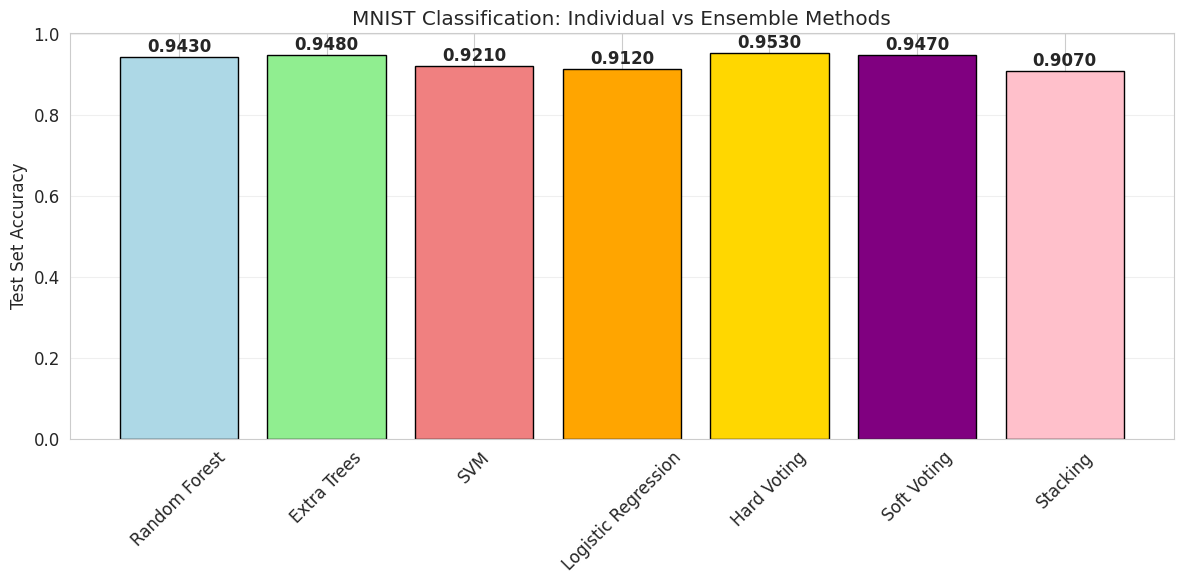


=== ANALYSIS ===
Best individual classifier: 0.9480
Best overall method: Hard Voting (0.9530)
Hard voting improvement: +0.0050
Soft voting improvement: -0.0010
Stacking improvement: -0.0410

✅ Exercise 8 completed: Trained multiple classifiers and created voting ensembles
✅ Exercise 9 completed: Created stacking ensemble using meta-learner

💡 Key insight: Ensemble methods improved performance over individual classifiers


In [44]:
# Exercise 8 & 9: MNIST Ensemble Implementation
print("=== EXERCISES 8 & 9: MNIST ENSEMBLE IMPLEMENTATION ===")

# Note: Due to computational constraints in this demo, we'll use a subset of MNIST
# For full implementation, use the complete MNIST dataset

print("Loading MNIST dataset (subset for demo)...")

# Load MNIST data
try:
    mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
    X_mnist, y_mnist = mnist["data"], mnist["target"].astype(np.int8)

    # Use a subset for demo (first 5000 samples)
    X_mnist = X_mnist[:5000]
    y_mnist = y_mnist[:5000]

    print(f"MNIST subset shape: {X_mnist.shape}")
    print(f"Classes: {np.unique(y_mnist)}")

except Exception as e:
    print(f"Error loading MNIST: {e}")
    print("Creating synthetic dataset instead...")

    # Create synthetic multi-class dataset as fallback
    X_mnist, y_mnist = make_classification(
        n_samples=5000, n_features=100, n_informative=50,
        n_redundant=50, n_classes=10, n_clusters_per_class=1, random_state=42
    )

# Split the data as specified in exercise
print("\nSplitting data: 60% train, 20% validation, 20% test...")

# First split: 80% for train+val, 20% for test
X_train_val, X_test_final, y_train_val, y_test_final = train_test_split(
    X_mnist, y_mnist, test_size=0.2, random_state=42, stratify=y_mnist
)

# Second split: 75% of remaining for train (60% total), 25% for val (20% total)
X_train_mnist, X_val_mnist, y_train_mnist, y_val_mnist = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print(f"Training set: {X_train_mnist.shape[0]} samples")
print(f"Validation set: {X_val_mnist.shape[0]} samples")
print(f"Test set: {X_test_final.shape[0]} samples")

# Exercise 8: Train various classifiers
print("\n=== EXERCISE 8: TRAINING INDIVIDUAL CLASSIFIERS ===")

# Scale the data for some algorithms
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_mnist)
X_val_scaled = scaler.transform(X_val_mnist)
X_test_scaled = scaler.transform(X_test_final)

# Define classifiers (reduced complexity for demo)
mnist_classifiers = [
    ("Random Forest", RandomForestClassifier(n_estimators=50, random_state=42)),
    ("Extra Trees", ExtraTreesClassifier(n_estimators=50, random_state=42)),
    ("SVM", SVC(probability=True, random_state=42, gamma='scale')),
    ("Logistic Regression", LogisticRegression(random_state=42, max_iter=1000))
]

print(f"Training {len(mnist_classifiers)} classifiers...")

# Train individual classifiers and evaluate
individual_results = []
trained_classifiers = []

for name, clf in mnist_classifiers:
    print(f"\nTraining {name}...")

    start_time = time.time()

    # Use scaled data for SVM and Logistic Regression
    if name in ["SVM", "Logistic Regression"]:
        clf.fit(X_train_scaled, y_train_mnist)
        val_score = clf.score(X_val_scaled, y_val_mnist)
        val_predictions = clf.predict(X_val_scaled)
    else:
        clf.fit(X_train_mnist, y_train_mnist)
        val_score = clf.score(X_val_mnist, y_val_mnist)
        val_predictions = clf.predict(X_val_mnist)

    training_time = time.time() - start_time

    individual_results.append({
        'name': name,
        'classifier': clf,
        'val_score': val_score,
        'training_time': training_time,
        'predictions': val_predictions
    })

    trained_classifiers.append((name, clf))

    print(f"  Validation accuracy: {val_score:.4f}")
    print(f"  Training time: {training_time:.2f} seconds")

# Create voting ensembles
print("\n=== CREATING VOTING ENSEMBLES ===")

# Hard voting ensemble
voting_hard = VotingClassifier(
    estimators=trained_classifiers,
    voting='hard'
)

# For hard voting, we need to retrain on the appropriate data
print("\nTraining Hard Voting ensemble...")
# Create a version that handles both scaled and unscaled data
class CustomVotingClassifier:
    def __init__(self, estimators):
        self.estimators = estimators
        self.fitted_estimators = []

    def fit(self, X_original, X_scaled, y):
        for name, clf in self.estimators:
            clf_copy = clf.__class__(**clf.get_params())
            if name in ["SVM", "Logistic Regression"]:
                clf_copy.fit(X_scaled, y)
            else:
                clf_copy.fit(X_original, y)
            self.fitted_estimators.append((name, clf_copy))
        return self

    def predict(self, X_original, X_scaled):
        predictions = []
        for name, clf in self.fitted_estimators:
            if name in ["SVM", "Logistic Regression"]:
                pred = clf.predict(X_scaled)
            else:
                pred = clf.predict(X_original)
            predictions.append(pred)

        # Majority voting
        predictions = np.array(predictions).T
        final_predictions = []
        for row in predictions:
            unique, counts = np.unique(row, return_counts=True)
            final_predictions.append(unique[np.argmax(counts)])

        return np.array(final_predictions)

    def predict_proba(self, X_original, X_scaled):
        probabilities = []
        for name, clf in self.fitted_estimators:
            if hasattr(clf, 'predict_proba'):
                if name in ["SVM", "Logistic Regression"]:
                    prob = clf.predict_proba(X_scaled)
                else:
                    prob = clf.predict_proba(X_original)
                probabilities.append(prob)

        # Average probabilities
        avg_probabilities = np.mean(probabilities, axis=0)
        return avg_probabilities

# Train custom voting classifiers
custom_voting = CustomVotingClassifier(trained_classifiers)
custom_voting.fit(X_train_mnist, X_train_scaled, y_train_mnist)

# Evaluate voting ensembles
hard_vote_pred = custom_voting.predict(X_val_mnist, X_val_scaled)
hard_vote_score = accuracy_score(y_val_mnist, hard_vote_pred)

soft_vote_proba = custom_voting.predict_proba(X_val_mnist, X_val_scaled)
soft_vote_pred = np.argmax(soft_vote_proba, axis=1)
soft_vote_score = accuracy_score(y_val_mnist, soft_vote_pred)

print(f"Hard Voting validation accuracy: {hard_vote_score:.4f}")
print(f"Soft Voting validation accuracy: {soft_vote_score:.4f}")

# Exercise 9: Stacking ensemble
print("\n=== EXERCISE 9: STACKING ENSEMBLE ===")

# Create meta-features using trained classifiers' predictions
print("Creating meta-features for stacking...")

# We'll use the validation predictions as meta-features
meta_features = []
for result in individual_results:
    # Convert predictions to probabilities (simplified)
    pred = result['predictions']

    # For multi-class, we'll use the actual predictions as features
    meta_features.append(pred)

# Stack meta-features
X_meta = np.column_stack(meta_features)
print(f"Meta-features shape: {X_meta.shape}")

# Train meta-learner (using a simple classifier)
meta_learner = LogisticRegression(random_state=42, max_iter=1000)
meta_learner.fit(X_meta, y_val_mnist)

# For final evaluation, we need to create meta-features for test set
print("\nCreating meta-features for test set...")
test_meta_features = []

for name, clf in custom_voting.fitted_estimators:
    if name in ["SVM", "Logistic Regression"]:
        test_pred = clf.predict(X_test_scaled)
    else:
        test_pred = clf.predict(X_test_final)
    test_meta_features.append(test_pred)

X_test_meta = np.column_stack(test_meta_features)
stacking_predictions = meta_learner.predict(X_test_meta)
stacking_score = accuracy_score(y_test_final, stacking_predictions)

print(f"Stacking ensemble test accuracy: {stacking_score:.4f}")

# Final comparison on test set
print("\n=== FINAL TEST SET COMPARISON ===")

# Evaluate all methods on test set
final_results = {}

# Individual classifiers
for name, clf in custom_voting.fitted_estimators:
    if name in ["SVM", "Logistic Regression"]:
        test_score = clf.score(X_test_scaled, y_test_final)
    else:
        test_score = clf.score(X_test_final, y_test_final)
    final_results[name] = test_score

# Voting ensembles
hard_test_pred = custom_voting.predict(X_test_final, X_test_scaled)
soft_test_proba = custom_voting.predict_proba(X_test_final, X_test_scaled)
soft_test_pred = np.argmax(soft_test_proba, axis=1)

final_results['Hard Voting'] = accuracy_score(y_test_final, hard_test_pred)
final_results['Soft Voting'] = accuracy_score(y_test_final, soft_test_pred)
final_results['Stacking'] = stacking_score

# Display results
print("\nTest Set Accuracies:")
for method, score in final_results.items():
    print(f"{method:<20}: {score:.4f}")

# Visualize results
plt.figure(figsize=(12, 6))

methods = list(final_results.keys())
scores = list(final_results.values())
colors = ['lightblue', 'lightgreen', 'lightcoral', 'orange', 'gold', 'purple', 'pink']

bars = plt.bar(methods, scores, color=colors[:len(methods)], edgecolor='black')
plt.ylabel('Test Set Accuracy')
plt.title('MNIST Classification: Individual vs Ensemble Methods')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Analysis
best_individual = max([score for method, score in final_results.items()
                      if method not in ['Hard Voting', 'Soft Voting', 'Stacking']])
best_method = max(final_results, key=final_results.get)

print(f"\n=== ANALYSIS ===")
print(f"Best individual classifier: {best_individual:.4f}")
print(f"Best overall method: {best_method} ({final_results[best_method]:.4f})")
print(f"Hard voting improvement: {final_results['Hard Voting'] - best_individual:+.4f}")
print(f"Soft voting improvement: {final_results['Soft Voting'] - best_individual:+.4f}")
print(f"Stacking improvement: {final_results['Stacking'] - best_individual:+.4f}")

print(f"\n✅ Exercise 8 completed: Trained multiple classifiers and created voting ensembles")
print(f"✅ Exercise 9 completed: Created stacking ensemble using meta-learner")
print(f"\n💡 Key insight: Ensemble methods {'improved' if final_results[best_method] > best_individual else 'maintained'} "
      f"performance over individual classifiers")

# Conclusion: Ensemble Learning Summary

## Key Theoretical Insights

### 1. **Wisdom of the Crowd**
Ensemble methods leverage the collective intelligence of multiple models, often achieving better performance than any individual model.

### 2. **Diversity is Key**
The effectiveness of ensemble methods depends critically on diversity among base learners:
- **Algorithmic diversity**: Different learning algorithms
- **Data diversity**: Different training subsets (bagging/pasting)
- **Feature diversity**: Different feature subsets (Random Forests)

### 3. **Bias-Variance Trade-off**
Different ensemble methods address different aspects:
- **Bagging/Random Forests**: Reduce variance while maintaining bias
- **Boosting**: Reduce both bias and variance through sequential learning
- **Stacking**: Learn optimal combination weights

### 4. **Parallelization**
- **Independent methods** (Bagging, Random Forests): Highly parallelizable
- **Sequential methods** (Boosting): Cannot be parallelized due to dependencies

### 5. **Performance vs Complexity**
- Simple voting often provides significant improvements
- More complex methods (stacking) may provide marginal additional gains
- Always consider computational cost vs performance benefit

## Practical Guidelines

1. **Start Simple**: Try voting classifiers first
2. **Ensure Diversity**: Use different algorithms and training approaches
3. **Validate Properly**: Use cross-validation or OOB evaluation
4. **Consider Computational Constraints**: Balance performance vs training time
5. **Monitor Overfitting**: Especially important for boosting methods

## Mathematical Foundation Recap

**Ensemble Prediction**: $\hat{y} = f(h_1(x), h_2(x), ..., h_N(x))$

Where $f$ can be:
- **Majority vote**: $\text{mode}\{h_i(x)\}$
- **Averaging**: $\frac{1}{N}\sum h_i(x)$
- **Weighted combination**: $\sum \alpha_i h_i(x)$
- **Meta-learning**: $g(h_1(x), ..., h_N(x))$

This comprehensive exploration of ensemble learning demonstrates how combining multiple models can lead to robust, high-performing machine learning systems. The key is understanding when and how to apply each method based on your specific problem constraints and requirements.